# Performance assessment with PRECIPITATION in ARPEGE-Climat PPE

<a id="top">This code</a> is assessing model performance based on Precipitation (pr) within the ARPEGE_Climat Perturbed Physics Ensemble. The metric is then used together with emulators (Multi Linear Regression) to constrain the feedback distribution in the ensemble, but also to study a subset of optimal parameter chosen with the total metric $E_{tot}$ and simulated with ARPEGE-Climat 6.3. <br> 

## It is a 6 steps method : 
### [Step 1 - EOF analysis](#EOF)
### [Step 2 - MultiLinReg predictions](#emulator)
### [Step 3 - Projection of observation dataset](#observation)
### [Step 4 - RMSE estimate](#RMSE)
### [Figure histograms](#histograms)
### [Step 5 - Optimisation](#optim)
### [Step 6 - Optimal subset of parameters](#selection)
### [Check correlation with simple RMSE](#correl)

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['pr']
variable = 'pr'
TITLE = 'Precipitation'
ylabel = '$E_{pr}$ (mm/day)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_file_npy = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"
path_file_csv = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv"
path_file_txt = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/txt"

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# <a id="EOF">Step 1 - EOF analysis</a> </li>

For each variable, we consider the climatological mean of the model outputs and we calculate empirical orthogonal functions (EOFs) of the control mean states of the ensemble. In contrast to conventional EOFs, the temporal dimension is replaced by the ensemble itself. This analysis provides a compact description of the spatial and temporal variability of the ensemble variance control climate in term of orthogonal functions, or statistical "modes". The resulting EOFs are spatial patterns, while their principal components ($PCs$) are the expansion coefficients showing the amplitude of the EOF in each ensemble member.

### Functions

In [5]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [6]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [7]:
def pc_plot(data, pc_nb, ymin, ymax, title, name_figure):
    #pc = solver.pcs(pcscaling=1)
    #pc = pc*-1

    # Plot the leading PC time series.
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    #ax.axvline(x=(8+1), color='red', alpha=0.5)
    #ax.axvline(x=(11+1), color='red', alpha=0.5)
    #ax.axvline(x=(23+1), color='red', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Members', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

### Get the data

In [8]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_pr_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_pr_xarr(path, filename, variables)

In [9]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_pr_xarr(path, filename, variables)
    i=i+1  

In [10]:
#amip['official'] = official_amip
amip['p1'] = p1_amip

### Create EOF input matrix

In [11]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

#amip_list[0] = amip['official']
amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    #j=i+1
    amip_list[i+1] = tmp
    i+=1

In [12]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])
matrix

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

### EOF analysis

In [13]:
# Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [14]:
## -- Save the weights 
np.save(path_file_npy+'/W_eof_2D_'+variable+'.npy', W_eof_2D)
np.save(path_file_npy+'/W_eof_3D_'+variable+'.npy', W_eof_3D)
np.save(path_file_npy+'/W_rmse_2D_'+variable+'.npy', W_rmse_2D)

In [15]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [16]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
anom_df =  anom.to_dataframe(name=str(variables[0])+'mean').drop(labels = 'height', axis=1)

In [17]:
anom_w = (anom*W_eof_3D)
anom_w

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [18]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

In [19]:
eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(npcs=100, pcscaling=1)

In [20]:
varFrac = solver.varianceFraction(neigs=100)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 100)>
array([0.28023055, 0.17486766, 0.08545674, 0.05723267, 0.04353731,
       0.03211438, 0.02572518, 0.02261979, 0.01882574, 0.01435854,
       0.0132021 , 0.01127715, 0.01031883, 0.00906161, 0.00827313,
       0.00770952, 0.00728811, 0.00640631, 0.00600718, 0.00563809,
       0.00523982, 0.00483964, 0.00472529, 0.00435955, 0.00427664,
       0.00404298, 0.00393698, 0.00391007, 0.00364497, 0.00359301,
       0.00343321, 0.00326574, 0.00315723, 0.00312866, 0.00299336,
       0.00292911, 0.00282262, 0.00276313, 0.00262929, 0.00259143,
       0.00251469, 0.00244203, 0.00241156, 0.00235965, 0.00235443,
       0.0022509 , 0.00217197, 0.00209733, 0.00205275, 0.00201995,
       0.00199547, 0.0019555 , 0.00191397, 0.00189165, 0.00187731,
       0.00179746, 0.00176989, 0.00169813, 0.00168808, 0.00165946,
       0.00162998, 0.00161633, 0.00155513, 0.00154134, 0.00148237,
       0.00145763, 0.00144382, 0.00141466, 0.00138283, 0.00135416,
       0.00133619, 0.00129176, 0.0012761 , 0.00124978, 0.00123566,
       0.00123232, 0.00118797, 0.0011856 , 0.00115112, 0.00112361,
       0.00109455, 0.00106378, 0.0010255 , 0.00102464, 0.00100367,
       0.00099435, 0.00098444, 0.00095707, 0.00093771, 0.00092718,
       0.00091143, 0.00090969, 0.00087191, 0.00084728, 0.00081686,
       0.00080001, 0.00078605, 0.00076437, 0.00074179, 0.0007232 ])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:  variance_fractions

In [26]:
## -- North test 
North = solver.northTest(neigs=50, vfscaled=True)
North

<xarray.DataArray 'typical_errors' (mode: 50)>
array([0.03904918, 0.02436721, 0.01190811, 0.00797518, 0.00606678,
       0.00447503, 0.00358472, 0.00315199, 0.0026233 , 0.00200081,
       0.00183967, 0.00157143, 0.00143789, 0.0012627 , 0.00115283,
       0.0010743 , 0.00101557, 0.0008927 , 0.00083708, 0.00078565,
       0.00073015, 0.00067439, 0.00065845, 0.00060749, 0.00059593,
       0.00056338, 0.0005486 , 0.00054486, 0.00050791, 0.00050067,
       0.00047841, 0.00045507, 0.00043995, 0.00043597, 0.00041712,
       0.00040816, 0.00039332, 0.00038503, 0.00036638, 0.00036111,
       0.00035041, 0.00034029, 0.00033604, 0.00032881, 0.00032808,
       0.00031365, 0.00030266, 0.00029226, 0.00028604, 0.00028147])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    long_name:  typical_errors

In [21]:
## --Number of modes needed for 90% of explained variance

cpt = 0
tmp = 0
for i in varFrac : 
    cpt+=1
    tmp = tmp+i
    #print(cpt, tmp)
    
    if tmp>=0.80 :
        break
print(tmp, cpt)

<xarray.DataArray 'variance_fractions' ()>
array(0.80710137)
Coordinates:
    mode     int64 14 15


### EOF 1 : plotting 

In [22]:
varFrac_list = []
for i in varFrac.values :
    tmp = round(i, 2)
    varFrac_list.append(tmp)
varFrac_list

[0.28,
 0.17,
 0.09,
 0.06,
 0.04,
 0.03,
 0.03,
 0.02,
 0.02,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

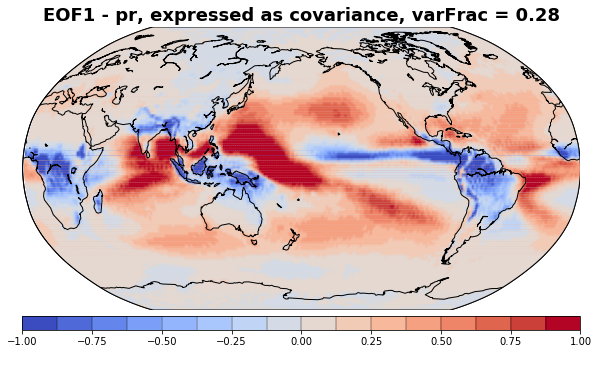

In [23]:
data = eof*(-1)
eof_nb = 1
title = "EOF1 - "+str(variables[0])+", expressed as covariance, varFrac = "+str(varFrac_list[0])
label_min = -1
label_max = 1
name_figure = "PPE2_EOF1map_"+str(variable)+".png"
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

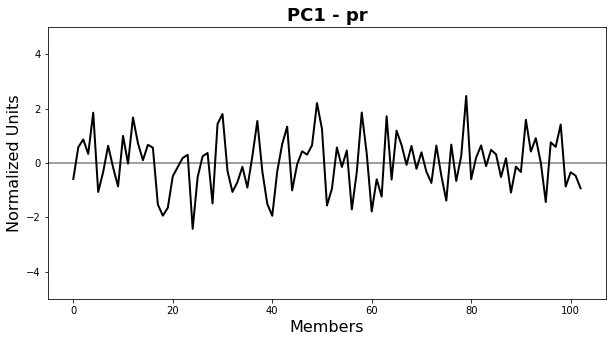

In [23]:
data = pc*(-1)
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - "+str(variables[0])
name_figure = "PPE2_EOF1pc_"+str(variables[0])+".png"
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 2 : plotting 

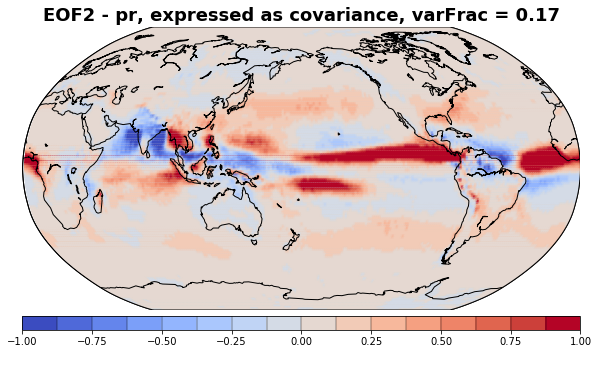

In [26]:
data = eof*(-1)
eof_nb = 2
title = "EOF2 - "+str(variables[0])+", expressed as covariance, varFrac = "+str(varFrac_list[1])
label_min = -1
label_max = 1
name_figure = 'PPE2_EOF2map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

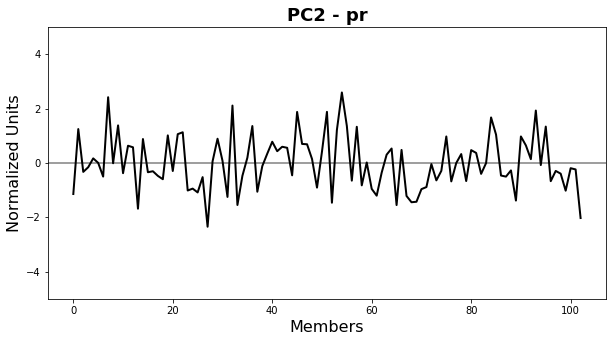

In [28]:
data = pc*(-1)
pc_nb = 2
ymin = -5
ymax = 5
title = 'PC2 - '+str(variable)
name_figure = 'PPE2_EOF2pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 3 : plotting

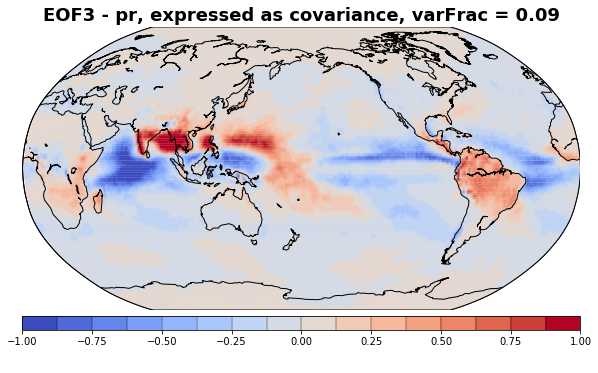

In [29]:
data = eof*(-1)
eof_nb = 3
title = 'EOF3 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[2])
label_min = -1
label_max = 1
name_figure = 'PPE2_EOF3map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

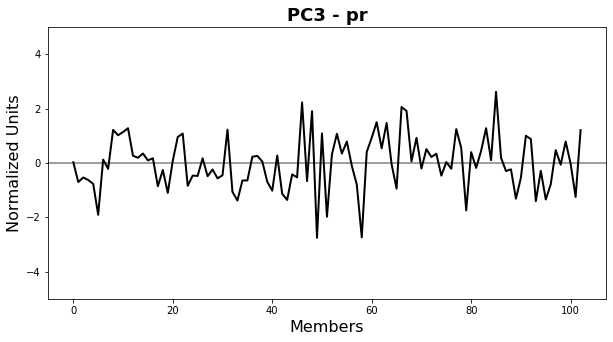

In [30]:
data = pc*(-1)
pc_nb = 3
ymin = -5
ymax = 5
title = 'PC3 - '+str(variable)
name_figure = 'PPE2_EOF3pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 4 : plotting 

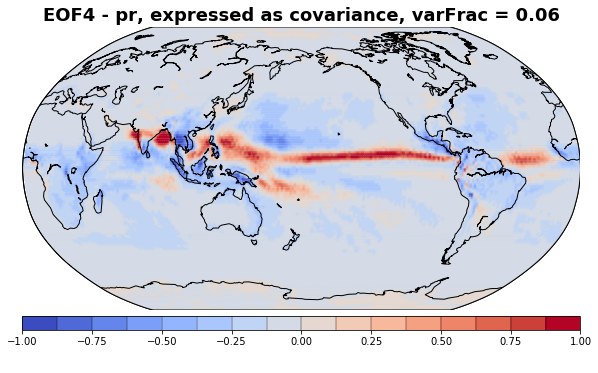

In [31]:
data = eof
eof_nb = 4
title = 'EOF4 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[3])
label_min = -1
label_max = 1
name_figure = 'PPE2_EOF4map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

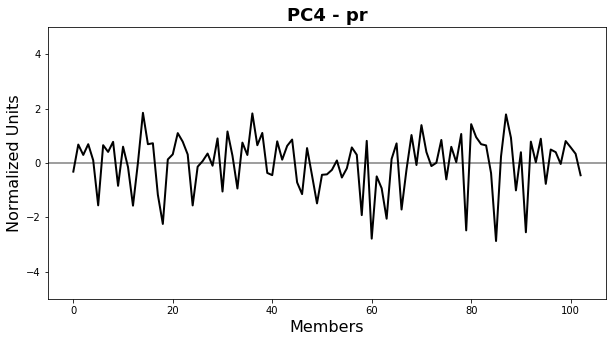

In [32]:
data = pc
pc_nb = 4
ymin = -5
ymax = 5
title = 'PC4 - '+str(variable)
name_figure = 'PPE2_EOF4pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 5 : plotting 

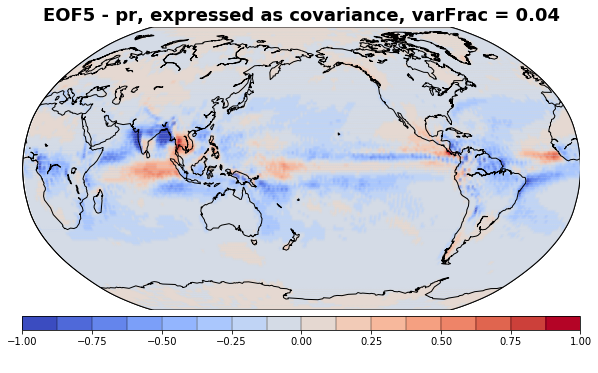

In [33]:
data = eof
eof_nb = 5
title = 'EOF5 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[4])
label_min = -1
label_max = 1
name_figure = 'PPE2_EOF5map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

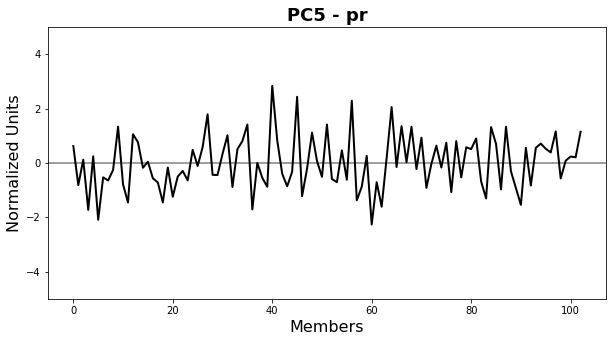

In [34]:
data = pc
pc_nb = 5
ymin = -5
ymax = 5
title = 'PC5 - '+str(variable)
name_figure = 'PPE2_EOF5pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### Save data

#### EOFs

In [35]:
for i in range(0,5,1) :
    j = i+1
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    # Save the numpy array in a file  
    EOF_df.to_pickle(path_file_npy+"/PPE2_EOFmap"+str(j)+"_"+str(variable)+".npy")

#### Principal Components

In [36]:
for i in range(0,5,1) :
    j = i+1
    pc_p1 = pc[0,i]
    PC = pc[1:,i]
    
    # Save the numpy array in a file   
    np.save(path_file_npy+'/p1_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_p1)
    np.save(path_file_npy+'/PPE2_EOF'+str(j)+'pc_'+str(variable)+'.npy', PC)

#### Variance explained, Mean and Anomalies

In [37]:
## --VarFrac 
np.save(path_file_npy+'/PPE2_varFrac_'+str(variable)+'.npy', varFrac)

## --Mean
mean_df.to_pickle(path_file_npy+'/PPE2_'+str(variable)+'_mean.npy')

## --Anom
anom_df.to_pickle(path_file_npy+'/PPE2_'+str(variable)+'_anom.npy')

### [Back to the top](#top)

# <a id="emulator">Step 2 - MultiLinReg predictions</a> </li>

Use of statistical emulators to predict, based on the perturbed parameter values, ARPEGE-Climat's outputs. The emulators must predict both the climate control mean state (here the global mean tas) and the global net feedback (in another code).  


The emulator is a simple multi linear regression model built and trained to predict the five first $PCs$ of the EOF analysis estimated in [Step 1](#EOF). It is expressed as followed : 
\begin{equation}
    Y = \Sigma_{j=1}^K a_jx_j + R 
    \label{eq_emulator}
\end{equation}

with $Y = PC_i$ the PC of one mode of the EOF analysis ($i=5$), $x_j$ the parameter values, $a_j$ the regression coefficients estimated based on the training of the model, $R$ the intercept and $K=30$ the number of perturbed parameter.

### Functions

In [38]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions_emulation
from Fonctions_emulation import Lasso_tunage
from Fonctions_emulation import Lasso_model
from Fonctions_emulation import plot_model_skill
from Fonctions_emulation import plot_model_skill_lines
from Fonctions_emulation import Lasso_pred
from Fonctions_emulation import MultiLinReg_model
from Fonctions_emulation import MultiLinReg_pred

### EOF 1 - prediction

In [39]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF1pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [40]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.005798404980784805
Coefficients: 
 [-0.33341868 -0.43467163 -0.27683339 -0.07065017  0.07721784 -0.32591082
 -0.04288339  0.06854515 -0.27994982 -0.0683014   0.12776027  0.06088086
 -0.2440023  -0.13837496  0.25386134  0.03403178 -0.07230781 -0.09731005
 -0.00916879  0.13900441 -0.00259658  0.01605582 -0.29183405 -0.16691382
  0.03866204  0.00920597 -0.0847659  -0.03351313 -0.2562742  -0.09386536]
Score: 
 0.876333409372697


y_true      y_eq members  members_0
0   -0.576649 -0.349595    p311          0
1   -0.862754 -0.740173    p312          1
2   -0.332272 -0.126373    p314          2
3   -1.847503 -1.232830    p316          3
4    1.070163  1.071807    p317          4
..        ...       ...     ...        ...
97  -1.411826 -0.730745    p465         97
98   0.870097  0.290179    p467         98
99   0.344547  0.449990    p469         99
100  0.470452  0.798637    p470        100
101  0.932981  0.474391    p471        101

[102 rows x 4 columns]

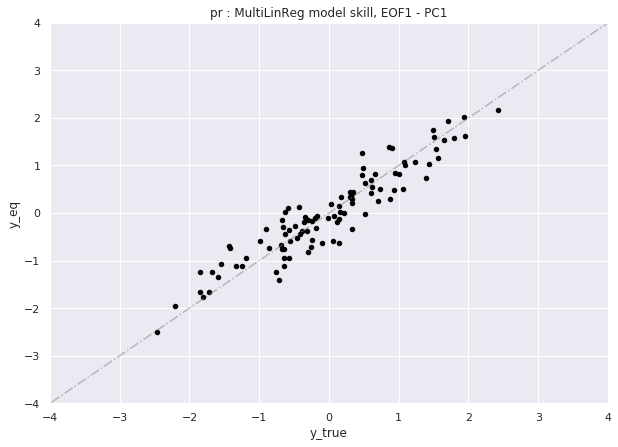

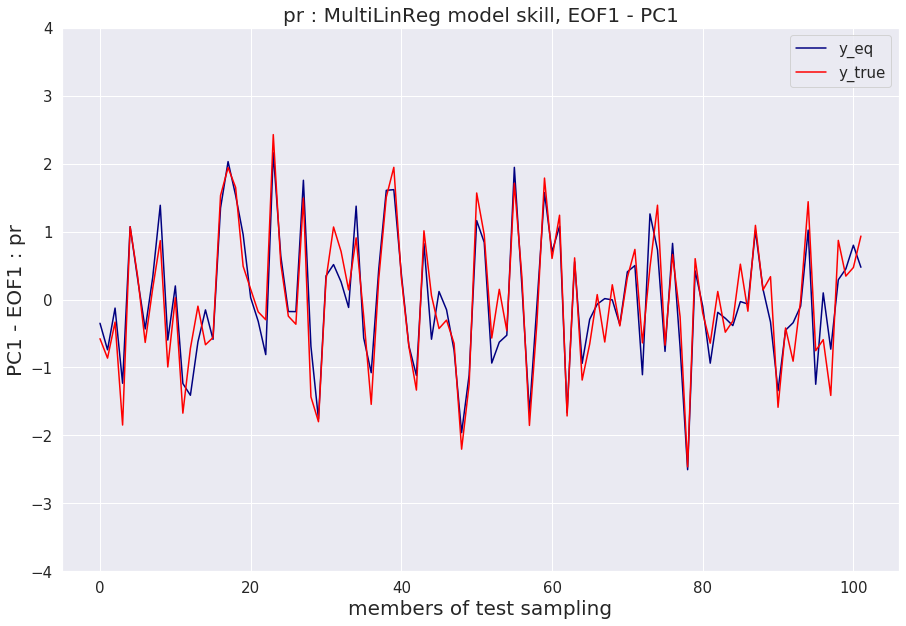

In [41]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF1 - PC1'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc1.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC1 - EOF1 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [42]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

y_pred   members
0      0.670288     102.0
1      1.095571     103.0
2     -0.528764     104.0
3     -0.114458     105.0
4      0.033719     106.0
...         ...       ...
99995 -0.390304  100097.0
99996 -0.569616  100098.0
99997  0.366495  100099.0
99998  2.176515  100100.0
99999  0.173894  100101.0

[100000 rows x 2 columns]

#### Save data

In [44]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof1_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof1_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 2 - prediction

In [45]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF2pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [46]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.011216057145113065
Coefficients: 
 [-0.29688603 -0.24905644 -0.24143597  0.0234201   0.01794951 -0.08103134
  0.06969068  0.02522136 -0.00200558  0.07759095  0.01046862 -0.09587455
  0.16975002  0.05819345 -0.36775988 -0.16154879 -0.00869724 -0.26973275
 -0.01228749 -0.14708581  0.13963774  0.26746319 -0.14124838 -0.26291526
 -0.03028162 -0.02639341 -0.051882    0.06770251  0.14158598 -0.20764968]
Score: 
 0.8089439285005849


y_true      y_eq members  members_0
0   -1.244866 -0.729446    p311          0
1    0.330346  0.160424    p312          1
2    0.158484  0.075633    p314          2
3   -0.166455 -0.030197    p316          3
4   -0.001736 -0.291973    p317          4
..        ...       ...     ...        ...
97   0.396202 -0.829372    p465         97
98   1.022319  0.647863    p467         98
99   0.194929  0.856033    p469         99
100  0.240466  0.786214    p470        100
101  2.027716  2.034857    p471        101

[102 rows x 4 columns]

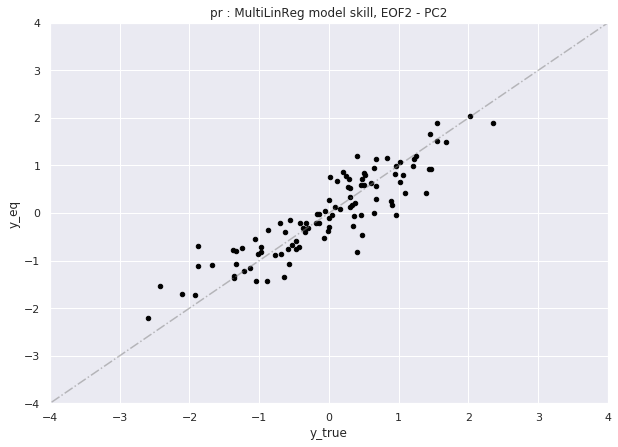

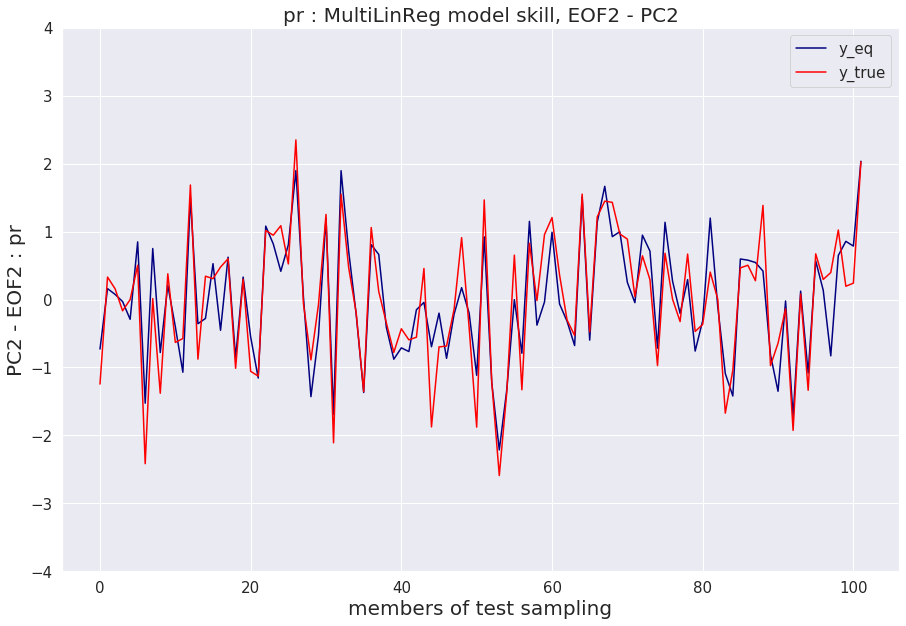

In [47]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF2 - PC2'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc2.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC2 - EOF2 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [48]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

y_pred   members
0     -0.790521     102.0
1     -0.999211     103.0
2      0.536298     104.0
3     -1.240433     105.0
4     -0.757257     106.0
...         ...       ...
99995  1.001070  100097.0
99996  0.788116  100098.0
99997 -0.201414  100099.0
99998  0.112053  100100.0
99999 -0.217926  100101.0

[100000 rows x 2 columns]

#### Save data

In [49]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof2_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof2_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 3 - prediction

In [50]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF3pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [51]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.00021646077740984003
Coefficients: 
 [ 0.06677524 -0.10580028 -0.25316467  0.07239096 -0.03673837 -0.42887744
 -0.03641515  0.11269384  0.25667932  0.1710069   0.03989154  0.00829093
  0.09692771  0.12202349 -0.01314534 -0.02755243 -0.1243247  -0.02813153
 -0.2233692   0.10236953 -0.10124303  0.1112978   0.00380964  0.37026623
  0.06676018 -0.12499396  0.00527336  0.13504188  0.0586661  -0.06741051]
Score: 
 0.600465290447694


y_true      y_eq members  members_0
0    0.704543 -0.561288    p311          0
1    0.536533  0.355691    p312          1
2    0.630465  1.170858    p314          2
3    0.771956 -0.116146    p316          3
4    1.908538  1.247458    p317          4
..        ...       ...     ...        ...
97   0.066118  0.321770    p465         97
98  -0.785519 -1.127879    p467         98
99   0.032738 -0.324298    p469         99
100  1.254922  1.307354    p470        100
101 -1.206135 -0.670022    p471        101

[102 rows x 4 columns]

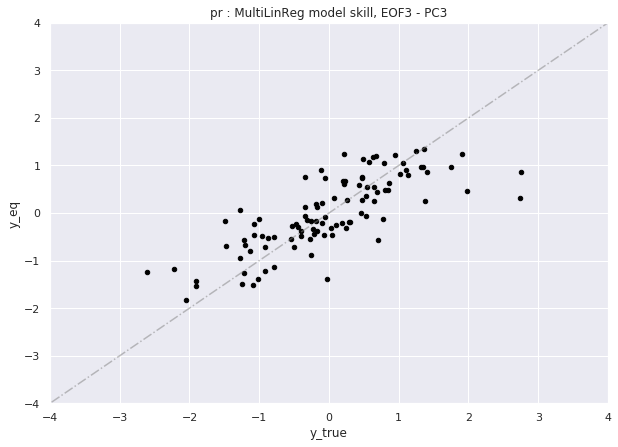

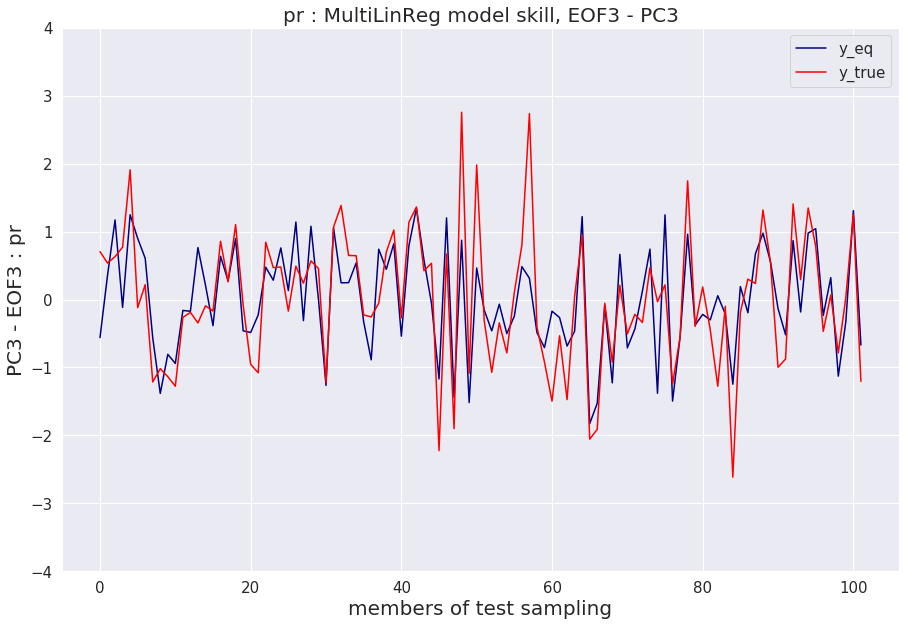

In [52]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF3 - PC3'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc3.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC3 - EOF3 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [53]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

y_pred   members
0      0.029989     102.0
1     -0.020168     103.0
2      0.526450     104.0
3      0.829454     105.0
4     -0.879496     106.0
...         ...       ...
99995 -0.608099  100097.0
99996  1.303263  100098.0
99997  0.134204  100099.0
99998  1.480660  100100.0
99999  0.112853  100101.0

[100000 rows x 2 columns]

#### Save data

In [54]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof3_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof3_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 4 - prediction

In [55]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF4pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [56]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.003149238906281432
Coefficients: 
 [-0.0284537  -0.37645046 -0.09321091 -0.01597777  0.10041647 -0.22841562
  0.02279787 -0.23194479  0.16809599 -0.20115473  0.11457313  0.08248767
  0.13505144 -0.097383    0.01315598  0.08164568 -0.01411422 -0.03292339
  0.13336951 -0.23015205 -0.01347741  0.18232029  0.24547982  0.1168113
 -0.1510594  -0.01794034  0.01470708 -0.02981232  0.16147674  0.1192359 ]
Score: 
 0.5150789874494225


y_true      y_eq members  members_0
0    0.674594  0.196868    p311          0
1    0.293066  0.844890    p312          1
2    0.688250 -0.241580    p314          2
3    0.095791  0.524190    p316          3
4   -1.561213 -1.323552    p317          4
..        ...       ...     ...        ...
97  -0.040638  0.162815    p465         97
98   0.803624  0.890600    p467         98
99   0.573655  0.656404    p469         99
100  0.334611  0.564439    p470        100
101 -0.454448  0.794150    p471        101

[102 rows x 4 columns]

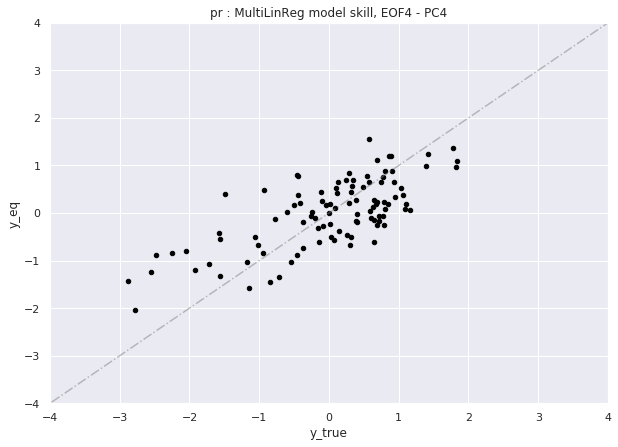

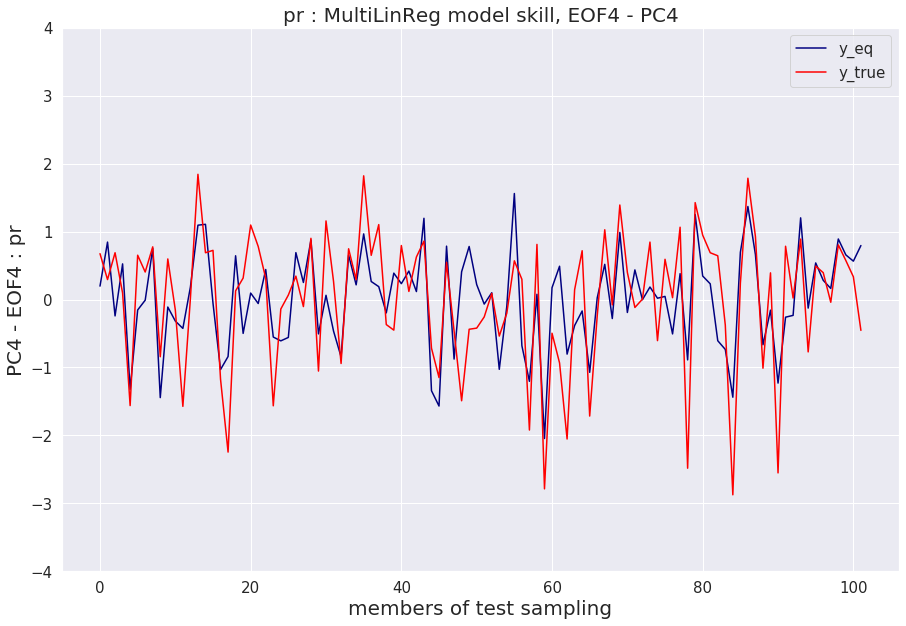

In [57]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF4 - PC4'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc4.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC4 - EOF4 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [58]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

y_pred   members
0      0.785455     102.0
1      0.917900     103.0
2     -0.336078     104.0
3      0.704410     105.0
4     -0.669543     106.0
...         ...       ...
99995  0.483360  100097.0
99996  1.504314  100098.0
99997  0.175639  100099.0
99998 -0.236451  100100.0
99999  0.633414  100101.0

[100000 rows x 2 columns]

#### Save data

In [59]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof4_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof4_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 5 - prediction

In [60]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF5pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [61]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.006092677808585578
Coefficients: 
 [-0.326258   -0.16949189 -0.11525135  0.11990843  0.00816156  0.16791186
  0.01785992 -0.15623163  0.0514168  -0.3533275   0.02802167  0.13750057
 -0.15833063 -0.01913616 -0.13371509 -0.19800393  0.05439649  0.21313793
  0.141515    0.08901615 -0.00792112 -0.18874137  0.01910705  0.20382306
  0.1321824   0.19569124 -0.12217717  0.09137055  0.36027345  0.0762341 ]
Score: 
 0.7558681345969127


y_true      y_eq members  members_0
0   -0.819153 -0.895417    p311          0
1    0.119754  0.032221    p312          1
2   -1.728777 -1.515952    p314          2
3    0.242596 -0.221611    p316          3
4   -2.090414 -1.837648    p317          4
..        ...       ...     ...        ...
97  -0.571056  0.596215    p465         97
98   0.080335  0.382470    p467         98
99   0.236374 -0.127508    p469         99
100  0.204161  0.313492    p470        100
101  1.146201  0.494777    p471        101

[102 rows x 4 columns]

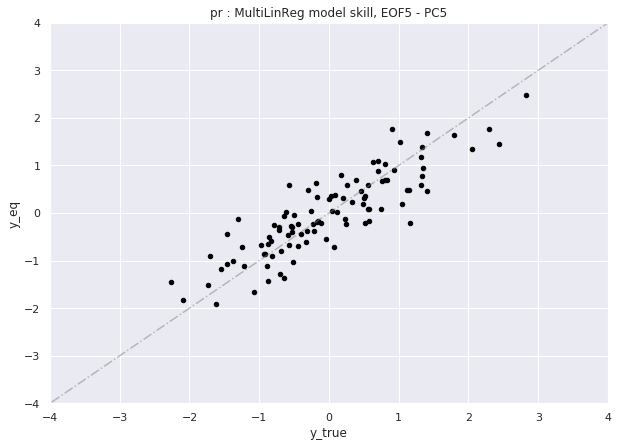

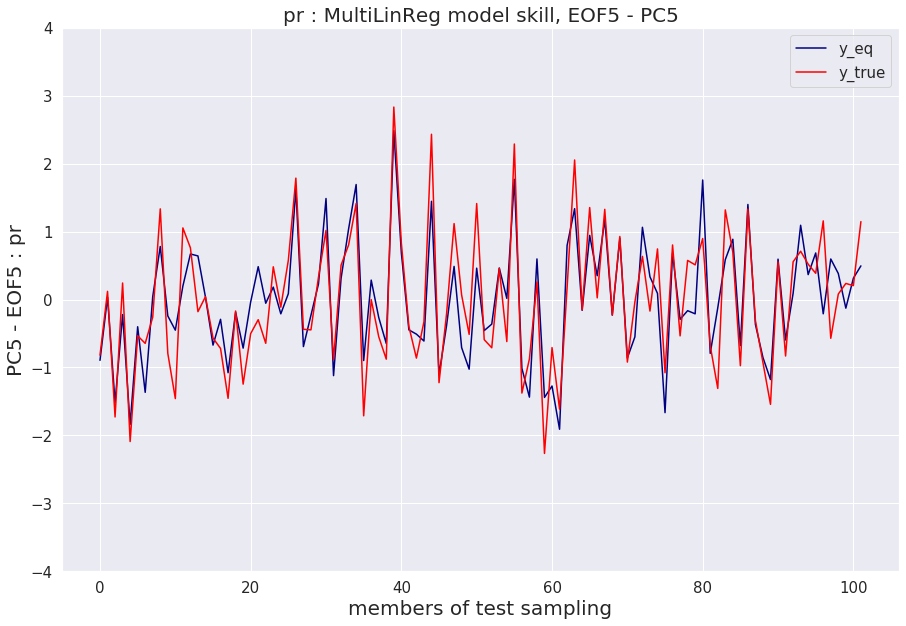

In [62]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF5 - PC5'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc5.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC5 - EOF5 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [63]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

y_pred   members
0     -0.062077     102.0
1      1.258599     103.0
2     -0.467179     104.0
3      0.215221     105.0
4     -0.347216     106.0
...         ...       ...
99995  1.211396  100097.0
99996 -0.452277  100098.0
99997  0.034514  100099.0
99998  0.571232  100100.0
99999 -0.165441  100101.0

[100000 rows x 2 columns]

#### Save data

In [64]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof5_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof5_'+variable+'.npy', 
        MultiLinReg_prediction)

### [Back to the top](#top)

# <a id="observation">Step 3 - Projection of observation dataset</a> </li>

In this section, we project the observations ($X_{obs}$) onto the EOFs calculated in [Step 1](#EOF). We call $U_{ens}$ the ensemble matrix of EOF amplitudes $w$ such as :  

$U_{ens} = \begin{pmatrix} 
                w_{1,1} & w_{2,1} & w_{3,1} & w_{4,1} & w_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                w_{1,102} & w_{2,102} & w_{3,102} & w_{4,102} & w_{5,102}
           \end{pmatrix}$ 
           
           
<br>
<br>
<br>
The ensemble matrix of spatial patterns is called $v_{ens}$ and is expresses such as : 

$v_{ens} = \begin{pmatrix} 
                eof1(lat,lon)  \\ 
                eof2(lat,lon)  \\ 
                eof3(lat,lon)  \\ 
                eof4(lat,lon)  \\ 
                eof5(lat,lon)  \\ 
           \end{pmatrix}$ 


<br>

The EOF analysis can be expresses as : 
$X_{ens} = U_{ens} \cdot v_{ens}$

And we want the EOF amplitudes of the observations within this basis such as : 

$X_{obs} = U_{obs} \cdot v_{ens}$ 

$U_{obs} = X_{obs} \cdot {v_{ens}}^{-1}$

With : 

$U_{obs} = \begin{pmatrix} 
                o_{1,1} & o_{2,1} & o_{3,1} & o_{4,1} & o_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                o_{1,102} & o_{2,102} & o_{3,102} & o_{4,102} & o_{5,102}
           \end{pmatrix}$ 

### Settings

In [75]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/regrid_CNRM/'
filename = 'pr_mon_mean_197901-198112_regrid.nc'
variable_obs = 'pr'

### Functions

In [66]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

### Get the data 

In [67]:
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
Mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[0.16115941, 0.16115941, 0.16115941, ..., 0.16115941, 0.16115941,
        0.16115941],
       [0.08960055, 0.08960055, 0.08960055, ..., 0.08960055, 0.08960055,
        0.08960055],
       [0.14128352, 0.14128352, 0.14128352, ..., 0.15915012, 0.14128352,
        0.14128352],
       ...,
       [0.70739219, 0.70739219, 0.70739219, ..., 0.64911432, 0.70739219,
        0.70739219],
       [0.64713049, 0.64713049, 0.64713049, ..., 0.64713049, 0.64713049,
        0.64713049],
       [0.55278562, 0.55278562, 0.55278562, ..., 0.55278562, 0.55278562,
        0.55278562]])
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'prmean'

In [68]:
pc1 = np.load(path_file_npy+'/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load(path_file_npy+'/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load(path_file_npy+'/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load(path_file_npy+'/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load(path_file_npy+'/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)

#PC_df

In [76]:
path = path_observation
variables = [variable_obs]
df_obs = load_monthly_clim(path, filename, variables)
df_obs

pr
month lat        lon                
1     -88.927735 0.00000    0.016181
                 1.40625    0.017889
                 2.81250    0.018091
                 4.21875    0.019936
                 5.62500    0.020032
...                              ...
12     88.927735 352.96875  0.485702
                 354.37500  0.466599
                 355.78125  0.466735
                 357.18750  0.467983
                 358.59375  0.467797

[393216 rows x 1 columns]

In [77]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.38347158 0.37245688 ... 0.503336 0.5036048

In [78]:
X_obs = obs[variable] - Mean
X_obs_bis = X_obs*W_eof_2D
U_obs_avg = solver.projectField(X_obs_bis, neofs=5, weighted=False, eofscaling=1)#[0,:]
U_obs_avg

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([ 1.65191504,  1.49066145, -0.32355807, -1.56810709,  2.81126511])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

### Save data

In [79]:
#Save the U_obs_avg 
np.save(path_file_npy+'/U_obs_'+variable+'.npy', U_obs_avg)

# Projection of CFMIP data

In [80]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['month']=pd.DatetimeIndex(df1['time']).month # time in years
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    
    return df_mean

In [132]:
# Download the amip dataframes and compute the radiative budget  

path = "/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/"
filename = "*_amip_*.nc"
CNRM_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/MRI-ESM2-0/amip/"
filename = "*_amip_*regrid.nc"
MRI_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/CanESM5/amip/"
filename = "standard_*_amip_*regrid.nc"
CAN_amip = load_monthly_clim(path, filename, variables)
CAN_amip

path = "/data/scratch/globc/peatier/CMIP6/MIROC6/"
filename = "*_amip_*regrid.nc"
MIROC_amip = load_monthly_clim(path, filename, variables)
MIROC_amip

path = "/data/scratch/globc/peatier/CMIP6/HadGEM3-GC31-LL/"
filename = "standard_*_amip_*regrid.nc"
HadGEM3_amip = load_monthly_clim(path, filename, variables)
HadGEM3_amip

path = "/data/scratch/globc/peatier/CMIP6/IPSL-CM6A-LR/"
filename = "*_amip_*regrid.nc"
IPSL_amip = load_monthly_clim(path, filename, variables)
IPSL_amip

path = "/data/scratch/globc/peatier/CMIP6/BCC-CSM2-MR/"
filename = "standard_*_amip_*regrid.nc"
BCC_amip = load_monthly_clim(path, filename, variables)
BCC_amip

pr  height
month lat        lon                        
1     -88.927735 0.00000    0.000002     2.0
                 1.40625    0.000002     2.0
                 2.81250    0.000002     2.0
                 4.21875    0.000002     2.0
                 5.62500    0.000002     2.0
...                              ...     ...
12     88.927735 352.96875  0.000006     2.0
                 354.37500  0.000006     2.0
                 355.78125  0.000006     2.0
                 357.18750  0.000006     2.0
                 358.59375  0.000006     2.0

[393216 rows x 2 columns]

In [133]:
df_obs = pd.DataFrame()
df_obs['CNRM'] = CNRM_amip[variables[0]]
df_obs['MRI'] = MRI_amip[variables[0]]
df_obs['CAN'] = CAN_amip[variables[0]]
df_obs['MIROC'] = MIROC_amip[variables[0]]
df_obs['HadGEM3'] = HadGEM3_amip[variables[0]]
df_obs['IPSL'] = IPSL_amip[variables[0]]
df_obs['BCC'] = BCC_amip[variables[0]]
#df_obs = df_obs.drop(['rsut', 'height'], axis = 1)
df_obs

CNRM       MRI       CAN     MIROC   HadGEM3  \
month lat        lon                                                           
1     -88.927735 0.00000    0.000002  0.000002  0.000002  0.000002  0.000002   
                 1.40625    0.000002  0.000002  0.000002  0.000002  0.000002   
                 2.81250    0.000002  0.000002  0.000002  0.000002  0.000002   
                 4.21875    0.000002  0.000002  0.000002  0.000002  0.000002   
                 5.62500    0.000002  0.000002  0.000002  0.000002  0.000002   
...                              ...       ...       ...       ...       ...   
12     88.927735 352.96875  0.000006  0.000005  0.000006  0.000003  0.000005   
                 354.37500  0.000006  0.000005  0.000006  0.000003  0.000005   
                 355.78125  0.000006  0.000005  0.000006  0.000003  0.000005   
                 357.18750  0.000006  0.000005  0.000006  0.000003  0.000005   
                 358.59375  0.000006  0.000005  0.000006  0.000003  0.000005   

                                IPSL       BCC  
month lat        lon                            
1     -88.927735 0.00000    0.000001  0.000002  
                 1.40625    0.000001  0.000002  
                 2.81250    0.000001  0.000002  
                 4.21875    0.000001  0.000002  
                 5.62500    0.000001  0.000002  
...                              ...       ...  
12     88.927735 352.96875  0.000006  0.000006  
                 354.37500  0.000006  0.000006  
                 355.78125  0.000006  0.000006  
                 357.18750  0.000006  0.000006  
                 358.59375  0.000006  0.000006  

[393216 rows x 7 columns]

In [83]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()*86400 
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Data variables:
    CNRM     (lat, lon) float64 0.1992 0.1992 0.1992 ... 0.6535 0.6535 0.6535
    MRI      (lat, lon) float64 0.1527 0.152 0.1513 ... 0.7101 0.7103 0.7106
    CAN      (lat, lon) float64 0.1428 0.1428 0.1398 ... 0.6491 0.6418 0.6418
    MIROC    (lat, lon) float64 0.104 0.1035 0.1031 ... 0.4774 0.4776 0.4779
    HadGEM3  (lat, lon) float64 0.1668 0.1664 0.1661 ... 0.6522 0.6528 0.6535
    IPSL     (lat, lon) float64 0.1578 0.1551 0.1527 ... 0.6418 0.647 0.6516
    BCC      (lat, lon) float64 0.198 0.1968 0.1956 ... 0.6695 0.6703 0.67

## Compute Anomaly

In [84]:
X_obs = {}
X_obs['CNRM'] = obs['CNRM'] - Mean
X_obs['MRI'] = obs['MRI'] - Mean
X_obs['CAN'] = obs['CAN'] - Mean
X_obs['MIROC'] = obs['MIROC'] - Mean
X_obs['HadGEM3'] = obs['HadGEM3'] - Mean
X_obs['IPSL'] = obs['IPSL'] - Mean
X_obs['BCC'] = obs['BCC'] - Mean
#X_obs

In [136]:
X_obs['CNRM'] = (X_obs['CNRM']*W_eof_2D)
U_CNRM_avg = solver.projectField(X_obs['CNRM'], neofs=5, weighted=False, eofscaling=1)

X_obs['MRI'] = (X_obs['MRI']*W_eof_2D)
U_MRI_avg = solver.projectField(X_obs['MRI'], neofs=5, weighted=False, eofscaling=1)

X_obs['CAN'] = (X_obs['CAN']*W_eof_2D)
U_CAN_avg = solver.projectField(X_obs['CAN'], neofs=5, weighted=False, eofscaling=1)

X_obs['MIROC'] = (X_obs['MIROC']*W_eof_2D)
U_MIROC_avg = solver.projectField(X_obs['MIROC'], neofs=5, weighted=False, eofscaling=1)

X_obs['HadGEM3'] = (X_obs['HadGEM3']*W_eof_2D)
U_HadGEM3_avg = solver.projectField(X_obs['HadGEM3'], neofs=5, weighted=False, eofscaling=1)

X_obs['IPSL'] = (X_obs['IPSL']*W_eof_2D)
U_IPSL_avg = solver.projectField(X_obs['IPSL'], neofs=5, weighted=False, eofscaling=1)

X_obs['BCC'] = (X_obs['BCC']*W_eof_2D)
U_BCC_avg = solver.projectField(X_obs['BCC'], neofs=5, weighted=False, eofscaling=1)

In [137]:
#Save the U_obs_avg 
np.save(path_file_npy+'/U_CNRM_'+variable+'.npy', U_CNRM_avg)
np.save(path_file_npy+'/U_MRI_'+variable+'.npy', U_MRI_avg)
np.save(path_file_npy+'/U_CAN_'+variable+'.npy', U_CAN_avg)
np.save(path_file_npy+'/U_MIROC_'+variable+'.npy', U_MIROC_avg)
np.save(path_file_npy+'/U_HadGEM3_'+variable+'.npy', U_HadGEM3_avg)
np.save(path_file_npy+'/U_IPSL_'+variable+'.npy', U_IPSL_avg)
np.save(path_file_npy+'/U_BCC_'+variable+'.npy', U_BCC_avg)

### [Back to the top](#top)

# <a id="RMSE">Step 4 - RMSE estimate</a> </li>

The model error as compared to observations is calculated by comparing the EOF amplitudes $w$ in each member with the projection of the observations $o$ on the model EOF basis through a Root Mean Square Error (RMSE). For a given member of the PPE, the error associated with the variable $s$ is : 

\begin{equation}
    E_{s} = \sqrt{\Sigma_i^N \frac{(w_{is}-o_{is})^2}{N}}
\end{equation}

with $i$ varying from $1$ to $N$, the number of modes considered. In the present study, we truncated the EOF after the 5th mode for each variable : $N=5$.

### Settings

In [87]:
product = 'GPCP'
ylabel = '$E_{pr}$ ($mm/day$)'
N_error = (128*256)

### Functions

In [90]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [91]:
def RMSE(mod, obs) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

In [92]:
def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs)
    return diff

### Get the data 

In [93]:
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

In [94]:
eofs=[]
for i in range(1,6,1) :
    eof_tmp = pd.read_pickle(path_file_npy+'/PPE2_EOFmap'+str(i)+'_'+variable+'.npy').to_xarray().to_array()
    eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
    eofs.append(eof_tmp)
                     
## --Combine the 5 modes for reconstruction
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

In [96]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

### p1 default model

In [97]:
pc_p1=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/p1_EOF'+str(i)+'pc_'+variable+'.npy')
    pc_p1.append(pc_tmp)

p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

In [98]:
pc = pc_p1
nb_dims = 2
X_rec_p1 = reconstruct_X(eofs_combined, pc, nb_dims)
X_rec_p1

<xarray.DataArray (lat: 128, lon: 256)>
array([[ 0.00061179,  0.00061179,  0.00061179, ...,  0.00061179,
         0.00061179,  0.00061179],
       [ 0.00023719,  0.00023719,  0.00023719, ...,  0.00023719,
         0.00023719,  0.00023719],
       [-0.00344627, -0.00344627, -0.00344627, ..., -0.00371241,
        -0.00344627, -0.00344627],
       ...,
       [-0.00829468, -0.00829468, -0.00829468, ..., -0.00854461,
        -0.00829468, -0.00829468],
       [-0.00802134, -0.00802134, -0.00802134, ..., -0.00802134,
        -0.00802134, -0.00802134],
       [-0.00353205, -0.00353205, -0.00353205, ..., -0.00353205,
        -0.00353205, -0.00353205]])
Coordinates:
    mode     <U4 'eofs'
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [99]:
E_p1 = RMSE_rec(X_rec_p1, X_rec_obs, Mean)
E_p1

<xarray.DataArray ()>
array(0.71881207)

In [100]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/regrid_CNRM/'
filename = 'pr_mon_mean_197901-198112_regrid.nc'
variable_obs = 'pr'

path = path_observation
variables = [variable_obs]
df_obs = load_monthly_clim(path, filename, variables)

obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.38347158 0.37245688 ... 0.503336 0.5036048

In [102]:
mod = amip_list[0]
observation = obs[variable]
RMSE_p1 = RMSE(mod, observation).values
RMSE_p1

array(1.37151437)

### CMIP6 models

In [138]:
nb_dims = 2

## Reconstruct and compute RMSE_rec 

filename = 'U_MRI_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_MRI = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_CAN_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_CAN = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_MIROC_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_MIROC = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_HadGEM3_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_HadGEM3 = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_IPSL_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_IPSL = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_BCC_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_BCC = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

### PPE

In [104]:
pc_PPE=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/PPE2_EOF'+str(i)+'pc_'+str(variable)+'.npy')
    pc_PPE.append(pc_tmp)

In [105]:
X_PPE = []
for i in range(0,102,1) :
    pc = [pc_PPE[0][i], pc_PPE[1][i], pc_PPE[2][i], pc_PPE[3][i], pc_PPE[4][i]]
    nb_dims = 2
    X_PPE_tmp = reconstruct_X(eofs_combined, pc, nb_dims)
    
    X_PPE.append(X_PPE_tmp)

In [107]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

In [109]:
E_PPE = []
RMSE_PPE = []
observation = obs[variable]
mod_list = amip_list[1:]  ## --Because amip_list[0] is p1

for i in range(0,len(X_PPE),1) :
    E_PPE_tmp = RMSE_rec(X_PPE[i], X_rec_obs, Mean)
    RMSE_PPE_tmp = RMSE(mod_list[i], observation)
    
    E_PPE.append(float(E_PPE_tmp))
    RMSE_PPE.append(float(RMSE_PPE_tmp))

## Check the correlation with simple RMSE

In [110]:
df_fig = pd.DataFrame(E_PPE, columns=['E_PPE'])
df_fig['RMSE_PPE'] = RMSE_PPE
df_fig

E_PPE  RMSE_PPE
0    1.714906  2.087098
1    1.442550  1.916497
2    1.469045  1.865745
3    1.895091  2.256500
4    1.255031  1.750502
..        ...       ...
97   1.675025  2.143384
98   0.839152  1.442432
99   1.036647  1.623806
100  1.054332  1.610798
101  0.604309  1.407086

[102 rows x 2 columns]

In [111]:
r = np.corrcoef(df_fig['E_PPE'], df_fig['RMSE_PPE'])
r = r[0,1].round(2)
r

0.98

In [116]:
E = df_fig['E_PPE']
R = df_fig['RMSE_PPE']
coeff1 = (E[90] - E[85])/(R[90] - R[85])
coeff2 = (E[50] - E[45])/(R[50] - R[45])
coeff3 = (E[100] - E[95])/(R[100] - R[95])
coeff4 = (E[80] - E[75])/(R[80] - R[75])
coeff5 = (E[60] - E[55])/(R[60] - R[55])
coeff6 = (E[101] - E[96])/(R[101] - R[96])
coeff = (coeff1 + coeff2 + coeff3 + coeff4 + coeff5)/5
line_tmp = R*coeff
intercept = E.mean() - line_tmp.mean()
line = np.arange(0.2,2.6,0.02)*coeff 
line = line + intercept

In [118]:
df_line = pd.DataFrame(line, columns=['line'])
df_line['x'] = np.arange(0.2,2.6,0.02)
df_line

line     x
0   -1.148199  0.20
1   -1.117503  0.22
2   -1.086807  0.24
3   -1.056111  0.26
4   -1.025415  0.28
..        ...   ...
115  2.381842  2.50
116  2.412538  2.52
117  2.443234  2.54
118  2.473930  2.56
119  2.504626  2.58

[120 rows x 2 columns]

In [114]:
diag_x = np.arange(0,3,0.02)
diag_y = np.arange(0,3,0.02)

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x2afc41a2a110> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


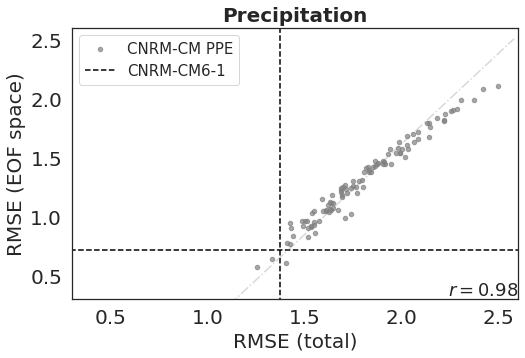

In [119]:
plt.figure(figsize=(8, 5))
    
ax = plt.gca()

df_fig.plot(kind='scatter', y='E_PPE', x='RMSE_PPE', color = 'gray', alpha=0.7, ax=ax)
df_line.plot(kind='line', y='line', x='x', color = 'gray', alpha=0.3, linestyle="-.", 
             label = '_nolegend_', ax=ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 4.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(RMSE_p1,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

ax.set_xlabel('RMSE (total)', size = 20)
ax.set_ylabel('RMSE (EOF space)', size = 20)
ax.set_title('Precipitation', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.0,r'$r = $'+str(r),horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

plt.xlim([0.3, 2.6])
plt.ylim([0.3, 2.6])

# Legend .................

legend = [ 'CNRM-CM PPE', 'CNRM-CM6-1']
ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
sns.set_style(style='white') 
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Multi-Linear Regression predictions

In [120]:
pc_pred=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/MultiLinReg_prediction_eof'+str(i)+'_'+variable+'.npy')
    pc_pred.append(pc_tmp)

In [121]:
pc_val=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/MultiLinReg_validation_eof'+str(i)+'_'+variable+'.npy')
    pc_val.append(pc_tmp)

In [123]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

In [124]:
E_pred = []
nb_dims = 2

## --E_tas of MultiLinReg predictions :
for i in range(0,len(pc_pred[0]),1) : ## --100 000 for a 100 000 LHS predictions 
    
    pc = [pc_pred[0][i], pc_pred[1][i], pc_pred[2][i], pc_pred[3][i], pc_pred[4][i]]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    E_tmp = RMSE_rec(X_rec_mod, X_rec_obs, Mean)
    E_pred.append(float(E_tmp))

In [125]:
E_val = []
nb_dims = 2

## --E_tas of MultiLinReg predictions :
for i in range(0,len(pc_val[0]),1) : ## --100 000 for a 100 000 LHS predictions 
    
    pc = [pc_val[0][i], pc_val[1][i], pc_val[2][i], pc_val[3][i], pc_val[4][i]]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    E_tmp = RMSE_rec(X_rec_mod, X_rec_obs, Mean)
    E_val.append(float(E_tmp))

### Get the feedbacks

In [139]:
Fdbck_PPE = np.load(file=path_file_npy+"/Net_feedbacks.npy")
Fdbck_multilinreg_val = np.load(file=path_file_npy+"/MultiLinReg_validation_FdbckN.npy")
Fdbck_multilinreg_pred = np.load(file=path_file_npy+"/MultiLinReg_prediction_FdbckN.npy")

Fdbck_CFMIP = np.load(file=path_file_npy+'/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

In [127]:
E_PPE_df = pd.DataFrame(E_PPE, columns=['E_PPE'])
E_PPE_df['Fdbck'] = Fdbck_PPE

In [129]:
E_multilinreg_val_df = pd.DataFrame(E_val, columns=['E_multilinreg_val'])
E_multilinreg_val_df['Fdbck_val'] = Fdbck_multilinreg_val

E_multilinreg_pred_df = pd.DataFrame(E_pred[0:100000], columns=['E_multilinreg_pred'])
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred
#E_multilinreg_pred_df

### Plotting

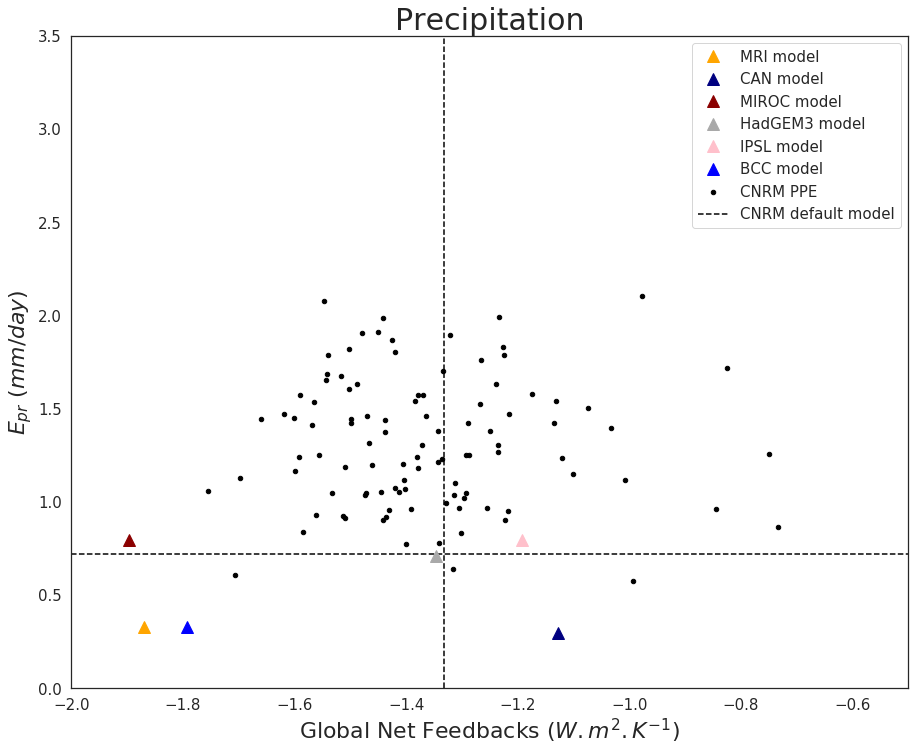

In [140]:
ax = plt.gca()

E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)


plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,3.5)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

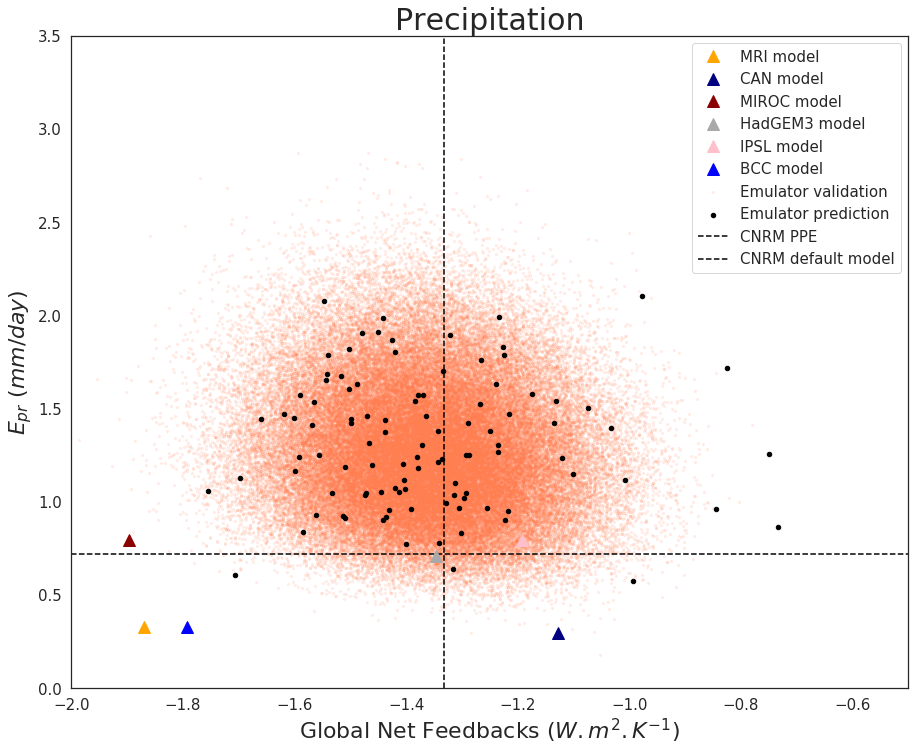

In [141]:
ax = plt.gca()

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#E_multilinreg_val_df.plot(kind='scatter', x='Fdbck_val', y='E_multilinreg_val', color='red', alpha=1, figsize=(15, 12), 
#                     marker='x', ax = ax)
E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='coral', alpha=0.1, figsize=(15, 12), marker='.', ax = ax)


E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'Emulator validation', 'Emulator prediction', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,3.5)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [142]:
fluxes_biases = E_PPE_df
fluxes_biases['E_multilinreg_val'] = E_multilinreg_val_df['E_multilinreg_val']
fluxes_biases['OSE_multilinreg'] = abs(fluxes_biases['E_PPE'] - fluxes_biases['E_multilinreg_val'])
fluxes_biases

E_PPE     Fdbck  E_multilinreg_val  OSE_multilinreg
0    1.714906 -0.825236           1.492337         0.222569
1    1.442550 -1.659636           1.452978         0.010428
2    1.469045 -1.215000           1.373570         0.095475
3    1.895091 -1.321641           1.652458         0.242633
4    1.255031 -0.750397           1.205668         0.049363
..        ...       ...                ...              ...
97   1.675025 -1.516367           1.541957         0.133068
98   0.839152 -1.584491           1.023887         0.184735
99   1.036647 -1.474525           0.955768         0.080879
100  1.054332 -1.445422           0.919503         0.134829
101  0.604309 -1.706865           0.898951         0.294642

[102 rows x 4 columns]

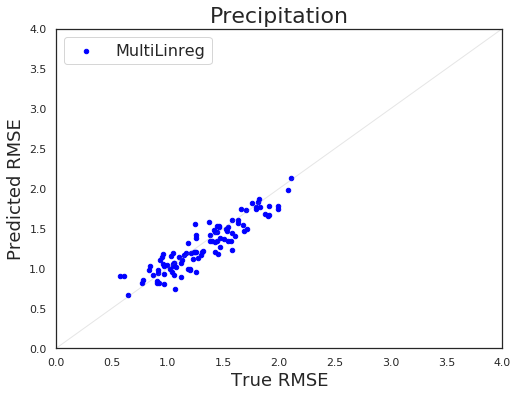

In [143]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title= TITLE 
fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
#fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_lasso_val', color='blue', alpha=0.6, 
#                     marker="o", ax = ax)

plt.xlabel('True RMSE', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted RMSE', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinreg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,4)
plt.xlim(0,4)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### Save data 

In [145]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save(path_file_npy+'/OSE_'+variable+'.npy', OSE)
np.save(path_file_npy+'/E_p1_'+variable+'.npy', E_p1)

In [146]:
RMSE_val = fluxes_biases['E_multilinreg_val']
np.save(path_file_npy+'/RMSE_multilinreg_val_'+variable+'.npy', RMSE_val)

In [147]:
## SAVE 
E_multilinreg_pred = E_multilinreg_pred_df['E_multilinreg_pred'].values
np.save(path_file_npy+'/RMSE_multilinreg_pred_'+variable+'.npy', E_multilinreg_pred)

E_PPE = E_PPE_df['E_PPE'].values
np.save(path_file_npy+'/RMSE_PPE_'+variable+'.npy', E_PPE)

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [148]:
E_p1 = np.load(path_file_npy+'/E_p1_'+variable+'.npy')
p1_feedback = np.load(path_file_npy+'/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file=path_file_npy+'/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file=path_file_npy+"/Net_feedbacks.npy")

In [150]:
E_MLR = np.load(path_file_npy+'/RMSE_multilinreg_pred_'+variable+'.npy')
Fdbck_MLR = np.load(file=path_file_npy+"/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
#MLR_df

In [151]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

Fdbck     E_MLR
0    -1.216964  0.493216
1    -1.296605  0.584674
2    -1.166431  0.717715
3    -1.426252  0.581220
4    -1.110015  0.648958
...        ...       ...
3420 -1.146426  0.702499
3421 -1.606959  0.713200
3422 -1.427530  0.706995
3423 -1.357204  0.699812
3424 -1.408280  0.707776

[3425 rows x 2 columns]

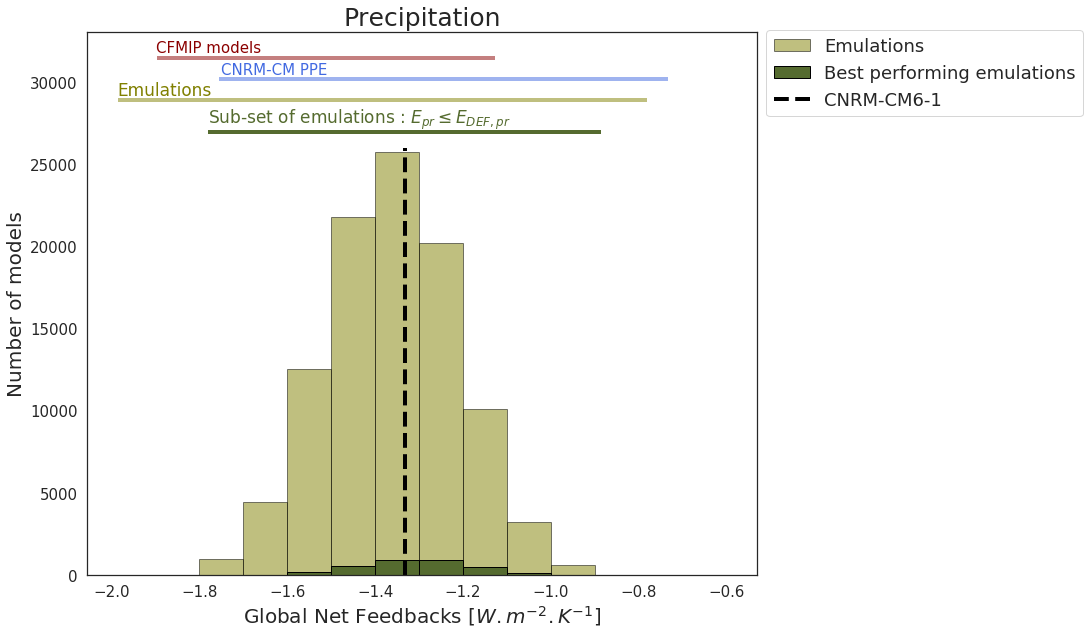

In [152]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{pr}\leq E_{DEF,pr}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [153]:
E_PPE = np.load(path_file_npy+'/RMSE_PPE_'+variable+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [154]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

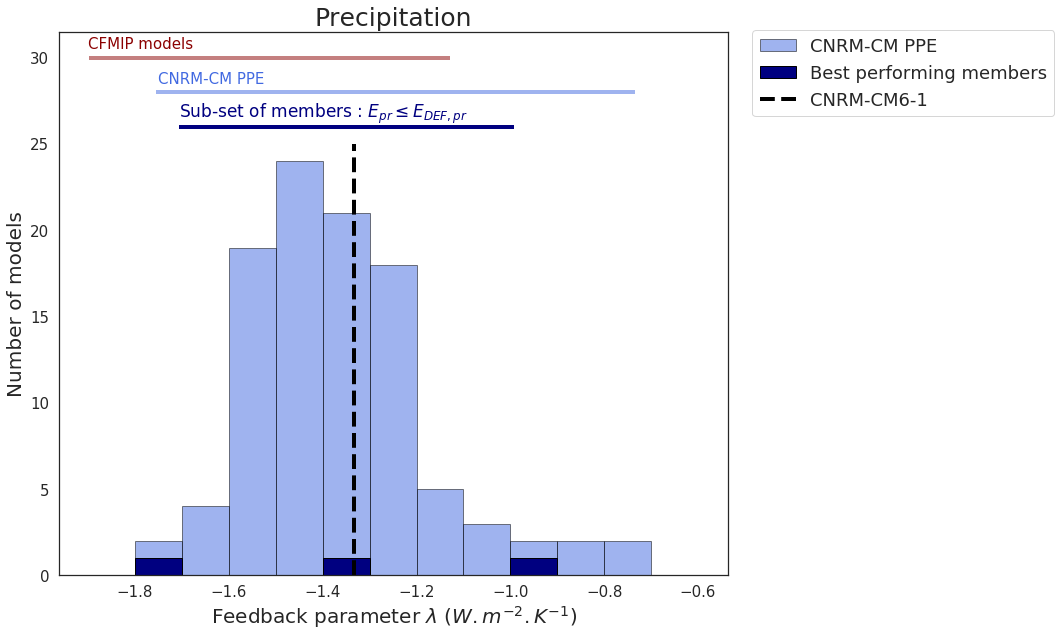

In [155]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{pr}\leq E_{DEF,pr}$', 
         color = 'navy', fontsize=17)

legend=['CNRM-CM PPE', 'Best performing members', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="optim">Step 5 - Optimisation</a> </li>

The objective here is to optimize the emulators described above in order to obtain a sub-set of the best parametrizations for each bins of feedback values. In other words, we aim to fine the parametrization which minimizes the error $E_{tot}$ given by the control mean state emulator, while showing a global net feedback value predicted by the feedback emulator within a chosen bin. It is a case of linear minimization with constraint and the optimizer used here comes from the SciPy Python's library and uses sequential least squares programming (SLSQP).

### Functions 

In [156]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

def RMSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_eof_2D, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs, W_rmse_2D)
    return diff

In [176]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_file_npy+"/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save(path_file_npy+'/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save(path_file_npy+'/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [172]:
## --Full function predict PC from x + reconstruct 3D field + compute partial RMSE

def function_RMSE_emulator_std(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 

    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims=2)
    
    U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
    pc = U_obs
    nb_dims = 2 
    X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    
    return E

def function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable, eofs_combined, 
                                   X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    return float(E)

## --Function feedbacks

def em_fdb_std(x) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file = path_file_npy+"/Net_feedbacks.npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [190]:
# -- FONCTION JACOBIAN 

def jacobian(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D) :
    
    ## -- Data
    
    Beta1 = np.load(path_file_npy+'/Beta1.npy')
    Beta2 = np.load(path_file_npy+'/Beta2.npy')
    Beta3 = np.load(path_file_npy+'/Beta3.npy')
    Beta4 = np.load(path_file_npy+'/Beta4.npy')
    Beta5 = np.load(path_file_npy+'/Beta5.npy')
    
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    nb_dims = 2 
    
    ## -- A = RMSE_rec
    A = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    #print(A)
    ## -- B = Sigma(2*(X_mod - X_rec_obs))
    toto = x - MEAN
    x_std = toto/STD
    
    pc1 = MultiLinReg_pred(x_std, 1, variable)
    pc2 = MultiLinReg_pred(x_std, 2, variable)
    pc3 = MultiLinReg_pred(x_std, 3, variable)
    pc4 = MultiLinReg_pred(x_std, 4, variable)
    pc5 = MultiLinReg_pred(x_std, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    
    add =  X_mod - X_rec_obs
    tmp = 2*eofs_combined*add
    B = tmp.sum(['lat', 'lon'])
    
    ## C = Beta*eofs_combined
    pc_beta = []
    for i in range(0, len(Beta1), 1) :
        tmp = ([Beta1[i], Beta2[i], Beta3[i], Beta4[i], Beta5[i]])
        pc_beta.append(tmp)
    C = xr.DataArray(pc_beta, dims = ['param', 'eofs'])
    
    ## -- jac = 1/(2*A) * B * C
    tmp1 = 1/(2*float(A)) 
    tmp2 = np.dot(C, B)
    jac = np.dot(tmp1, tmp2)
    
    return jac

In [178]:
## --Functions constraints on the feedbacks

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


## --Functions optimization

def Optimization(x_best, ind, xlim, variable, eofs_combined, X_rec_obs, 
                 Mean, W_eof_2D, W_rmse_2D) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_emulator(x0, variable, eofs_combined, X_rec_obs, 
                                        Mean, W_eof_2D, W_rmse_2D)
        print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_emulator,  x0, 
                       args=(variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D), 
                       method='SLSQP', jac = jacobian,
                       bounds=xlim, constraints=(cons1, cons2),
                       options={'disp': True, 'ftol' : 0.001, 'maxiter' : 100})    
                        # , 'maxiter' : 250   jac = jacobian, , tol = 0.001
                        # constraints=(cons1, cons2),
    

        tmp_fun = function_RMSE_emulator(sol.x, variable, eofs_combined, X_rec_obs, 
                                         Mean, W_eof_2D, W_rmse_2D)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [161]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

### Get the data

In [162]:
E_p1 = np.load(path_file_npy+'/E_p1_'+variable+'.npy')
p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

In [163]:
Fdbck_PPE = np.load(file=path_file_npy+'/Net_feedbacks.npy')
E_PPE = np.load(path_file_npy+'/RMSE_PPE_'+variable+'.npy')

E_PPE_df = pd.DataFrame()
E_PPE_df['Fdbck'] = Fdbck_PPE
E_PPE_df['RMSE'] = E_PPE
E_PPE_df

Fdbck      RMSE
0   -0.825236  1.714906
1   -1.659636  1.442550
2   -1.215000  1.469045
3   -1.321641  1.895091
4   -0.750397  1.255031
..        ...       ...
97  -1.516367  1.675025
98  -1.584491  0.839152
99  -1.474525  1.036647
100 -1.445422  1.054332
101 -1.706865  0.604309

[102 rows x 2 columns]

In [165]:
E_multilinreg_pred = np.load(file=path_file_npy+'/RMSE_multilinreg_pred_'+variable+'.npy')
Fdbck_multilinreg_pred = np.load(file=path_file_npy+'/MultiLinReg_prediction_FdbckN.npy')


E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred)
E_multilinreg_pred_df['E_multilinreg_pred'] = E_multilinreg_pred
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred[0:100000]
E_multilinreg_pred_df = E_multilinreg_pred_df.drop([0], axis=1)
E_multilinreg_pred_df

E_multilinreg_pred  Fdbck_pred
0                1.226157   -1.499698
1                1.148225   -1.339351
2                1.302973   -1.323732
3                1.523161   -1.541909
4                1.307891   -1.346961
...                   ...         ...
99995            1.124317   -1.453679
99996            1.474320   -1.410350
99997            1.095821   -1.296397
99998            0.900739   -1.299809
99999            1.204606   -1.201982

[100000 rows x 2 columns]

### Initial guess for Optimization 1

In [166]:
E_multilinreg_pred_df['Fdbck_pred_round'] = E_multilinreg_pred_df['Fdbck_pred'].round(decimals=2)
E_multilinreg_pred_df = E_multilinreg_pred_df.set_index('Fdbck_pred_round')
E_multilinreg_pred_df['members'] = range(0,100000,1) 
#E_multilinreg_pred_df        

In [167]:
new_df=pd.DataFrame()
new_df['E_multilinreg_pred_best'] = E_multilinreg_pred_df['E_multilinreg_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
#new_df

In [168]:
list_RMSE = new_df['E_multilinreg_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_pred_df['E_multilinreg_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_multilinreg_pred_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
#new_df

### Optimization 1 

In [169]:
LHS = np.load(file=path_file_npy+"/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [170]:
param = pd.read_csv(path_file_csv+"/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [191]:
sol_df = Optimization(x_best, 0.0001, xlim, variable, eofs_combined, X_rec_obs, 
                      Mean, W_eof_2D, W_rmse_2D)
#sol_df

fun_x0 = 1.3322810327332906
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3324404766819697
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.6579713544420336
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6578756426366938
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.1907583527802994
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1910161825608194
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.4438835735434485
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4435835196268056
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.5891446269801022
Optimization terminated 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5375450456202219
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.531386744484852
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5303201358721201
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
fun_x0 = 0.4140678333757026
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4137986078051585
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.5497018395859017
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5472879555718959
            Iterations: 3
            Function evaluations: 34
            Gradient evaluations: 3
fun_x0 = 0.5098840299795485
Optimization terminated successfully.    (Exit mode 0

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42000331251697615
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
fun_x0 = 0.4472628931046334
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4435733582621625
            Iterations: 3
            Function evaluations: 34
            Gradient evaluations: 3
fun_x0 = 0.363368666429016
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.36254496026633054
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.43923501678071614
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4382768623461245
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.34550792541483766
Optimization terminated successfully.    (Exit mo

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6887476079980841
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
fun_x0 = 0.8167251792073393
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8157841758339676
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.9637201622694902
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.8389360043465272
            Iterations: 100
            Function evaluations: 1046
            Gradient evaluations: 96
fun_x0 = 0.9922905900075498
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9886931480757036
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
fun_x0 = 0.9640623258464398
Positive directional derivative for li

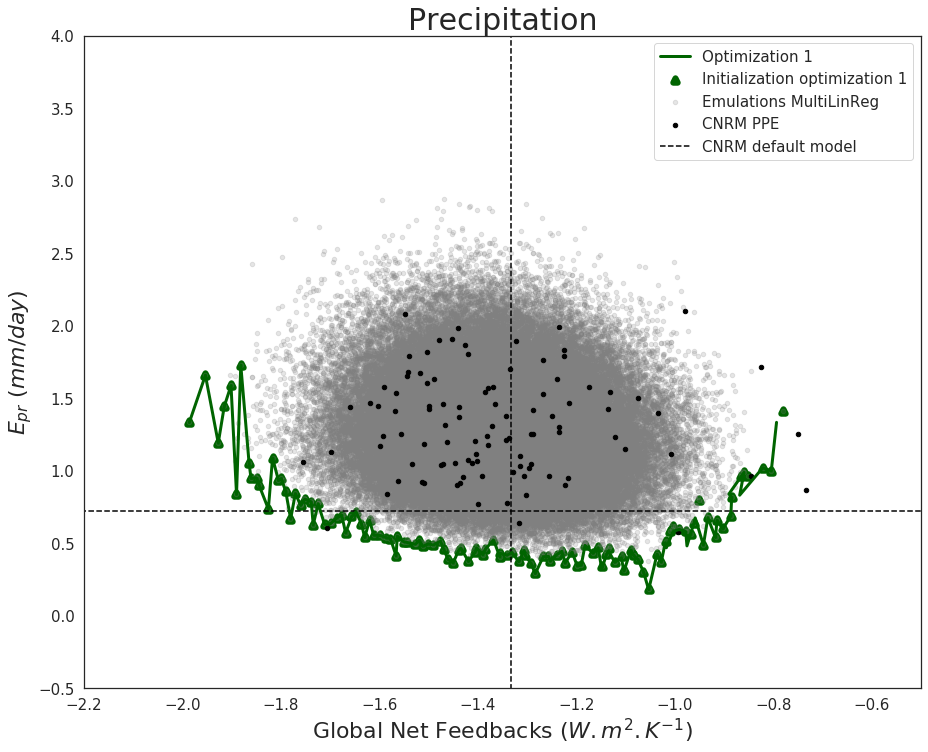

In [192]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Initial guess for Optimization 2 (param. moothing)

In [193]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

Fdbck  x1_smth_1  x2_smth_1  x3_smth_1  x4_smth_1  x5_smth_1  \
0   -1.985864   0.101277   0.935376   2.307758  29.825597  -0.079693   
1   -1.953157   0.105605   0.661592   2.258800  23.658130  -0.081942   
2   -1.927063   0.087856   0.675661   1.873155  22.882876  -0.170898   
3   -1.914878   0.090321   0.773091   2.095866  21.122564  -0.337138   
4   -1.901159   0.098212   0.720936   2.188979  18.917660  -0.342423   
..        ...        ...        ...        ...        ...        ...   
108 -0.859131   0.238760   2.397464   0.842108  19.122174  -0.390129   
109 -0.868042   0.226937   2.501938   0.913737  15.062942  -0.386950   
110 -0.821091   0.232923   2.586129   1.016295  17.056049  -0.366165   
111 -0.803844   0.258455   2.588522   1.295372  22.102471  -0.312105   
112 -0.793162   0.270206   2.654857   1.124763  28.266828  -0.423457   

     x6_smth_1  x7_smth_1  x8_smth_1  x9_smth_1  ...  x21_smth_150  \
0     8.930883   3.063288   0.005119   0.000707  ...     -2.508778   
1     8.173294   4.065608   0.006644   0.000754  ...     -2.545897   
2     8.388199   2.464171   0.006144   0.000652  ...     -2.581493   
3     9.240923   0.849096   0.004638   0.000532  ...     -2.614104   
4     8.422001   0.507275   0.002606   0.000530  ...     -2.642395   
..         ...        ...        ...        ...  ...           ...   
108   2.137394   6.112411   0.004316   0.000544  ...     -2.570685   
109   1.596696   5.450117   0.003584   0.000651  ...     -2.543219   
110   0.601641   4.759130   0.003542   0.000657  ...     -2.514559   
111   0.698888   4.721935   0.005752   0.000707  ...     -2.485111   
112   1.887828   6.403269   0.007762   0.000721  ...     -2.455273   

     x22_smth_150  x23_smth_150  x24_smth_150  x25_smth_150  x26_smth_150  \
0      -25.309420      0.074976     14.083627      0.000044      0.911296   
1      -26.155600      0.075984     13.785681      0.000045      0.906077   
2      -26.991419      0.076972     13.486811      0.000045      0.900950   
3      -27.807112      0.077918     13.186246      0.000046      0.896001   
4      -28.594049      0.078803     12.883511      0.000046      0.891309   
..            ...           ...           ...           ...           ...   
108    -44.568045      0.018325      7.423149      0.000051      0.607877   
109    -45.148436      0.018325      7.815053      0.000049      0.592245   
110    -45.763126      0.018349      8.225442      0.000047      0.576163   
111    -46.401465      0.018390      8.648376      0.000045      0.559773   
112    -47.051868      0.018439      9.077652      0.000043      0.543228   

     x27_smth_150  x28_smth_150  x29_smth_150  x30_smth_150  
0        0.653218      0.507015      0.534775      6.130568  
1        0.665089      0.522295      0.539963      5.891228  
2        0.676656      0.537409      0.545117      5.655566  
3        0.687629      0.552197      0.550206      5.427069  
4        0.697748      0.566509      0.555207      5.208852  
..            ...           ...           ...           ...  
108      0.583448      0.905190      0.904474      6.214819  
109      0.574597      0.922847      0.909574      6.525071  
110      0.565584      0.941256      0.915007      6.847619  
111      0.556461      0.960183      0.920669      7.178700  
112      0.547282      0.979373      0.926446      7.514151  

[113 rows x 4501 columns]

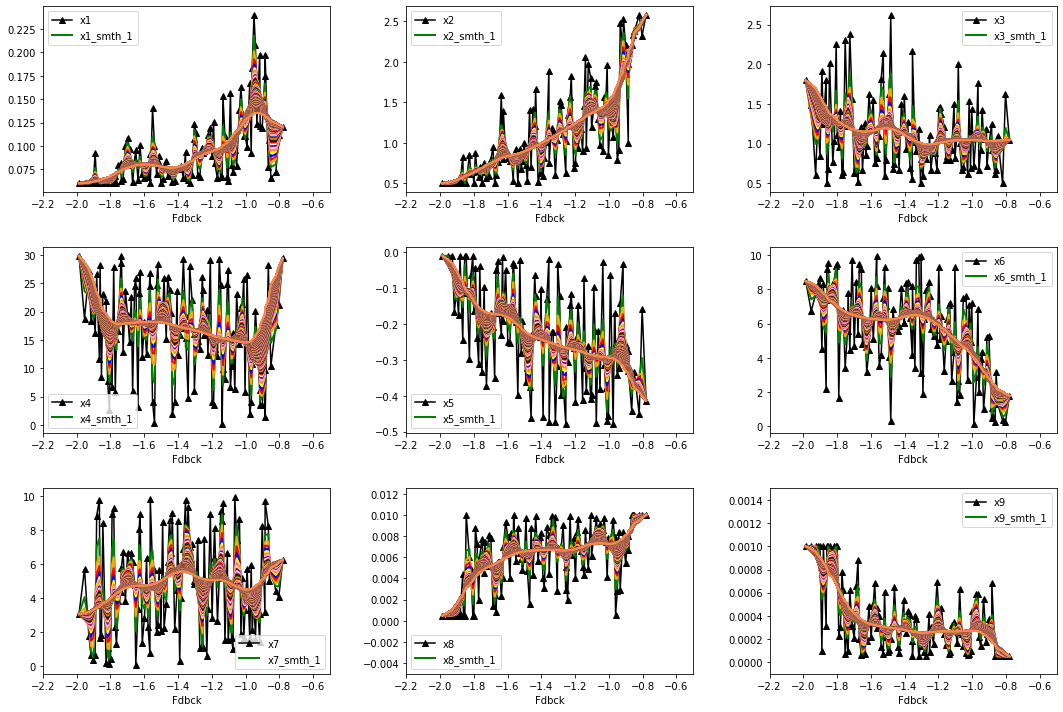

In [71]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Optimization 2

In [194]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.10127743, 0.93537603, 2.30775837, ..., 0.50701478, 0.53477471,
        6.13056834],
       [0.09914852, 0.93129579, 2.24531842, ..., 0.52229524, 0.53996282,
        5.89122762],
       [0.09704566, 0.92708305, 2.18311804, ..., 0.53740946, 0.54511692,
        5.65556576],
       ...,
       [0.25320305, 2.51200794, 1.11066511, ..., 0.94125639, 0.91500723,
        6.84761896],
       [0.26168637, 2.58326836, 1.11765094, ..., 0.96018328, 0.92066873,
        7.1786997 ],
       [0.27020599, 2.65485688, 1.12476334, ..., 0.97937337, 0.92644602,
        7.514151  ]])

In [195]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_emulator(i, variable, eofs_combined, 
                                 X_rec_obs, Mean, W_eof_2D,W_rmse_2D)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

Fdbck      RMSE
0   -1.985864  1.332440
1   -1.953157  1.290707
2   -1.927063  1.249411
3   -1.914878  1.208641
4   -1.901159  1.168490
..        ...       ...
108 -0.859131  1.033529
109 -0.868042  1.105160
110 -0.821091  1.179493
111 -0.803844  1.255824
112 -0.793162  1.333388

[113 rows x 2 columns]

In [196]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variable, eofs_combined, 
                                 X_rec_obs, Mean, W_eof_2D,W_rmse_2D)
#sol_df_2

fun_x0 = 1.3324404766819697
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3322810072026987
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.2907069406872531
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2905565176571834
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.2494111186954469
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2492753770248537
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.2086409878197755
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2090122918059403
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.1684898148485954
Optimization terminated 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.49260944335020834
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.48437365813067784
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4837494236834407
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.47593300574755365
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4752710717251659
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.4679135149463995
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.467784492311373
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.4602942157819328
Optimization terminated successfully.    (Exit mod

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.332006970766126
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.33190113519226677
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3311170221458492
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.3312680569167679
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.33043584946703675
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.33089188512600426
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3300281450429823
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 0.3307715760732797
Optimization terminated successfully.    (Exit mod

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8364407317314737
            Iterations: 3
            Function evaluations: 34
            Gradient evaluations: 3
fun_x0 = 0.9007557029028699
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8977369384112962
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
fun_x0 = 0.965221053529907
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9642660271810413
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
fun_x0 = 1.0335285421566913
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0303253613000196
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
fun_x0 = 1.1051598889557823
Optimization terminated successfully.    (Exit mode 0

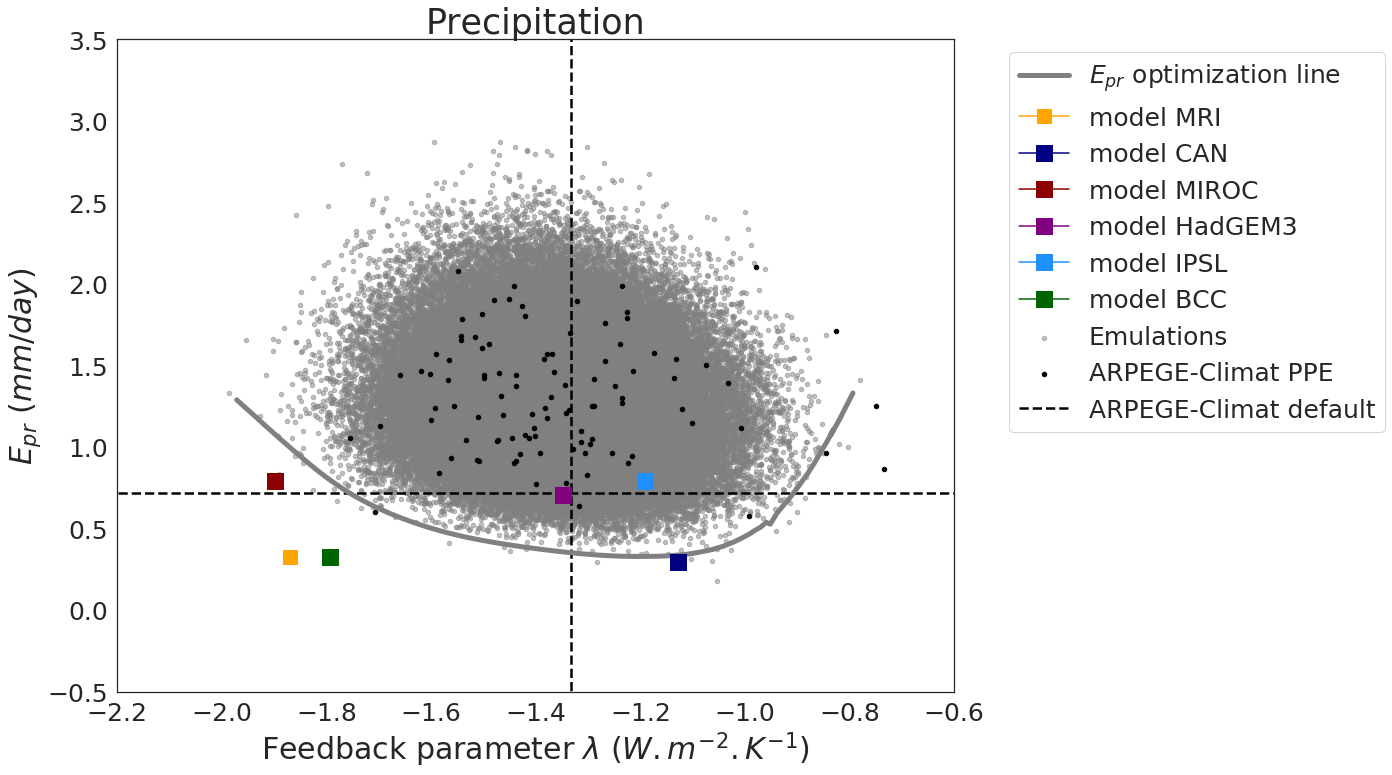

In [199]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.5, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), alpha=1.0,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{pr}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title(TITLE, fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-0.5,3.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save data

In [200]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save(path_file_npy+'/RMSE_optim2_'+variable+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save(path_file_npy+'/Fdbck_optim2_'+variable+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

## Projection of sub-set on EOF basis

### Settings 

In [5]:
ENSEMBLE = 'ENSEMBLE4_selection/'
path_PPE_short = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
product = 'GPCP'

In [7]:
nb_p_select = ['p860', 'p861', 'p862', 'p864', 'p865', 'p866', 'p867', 'p868', 'p869', 
                    'p870', 'p871', 'p872', 'p873','p874', 'p875', 'p876', 'p877', 'p878', 'p879',
                    'p880', 'p881', 'p882', 'p883']
len(nb_p_select)

23

In [8]:
N_error=128*256

### Functions

In [9]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

def RMSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_eof_2D, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs, W_rmse_2D)
    return diff

In [10]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_file_npy+"/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save(path_file_npy+'/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save(path_file_npy+'/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [11]:
## --Full function predict PC from x + reconstruct 3D field + compute partial RMSE

def function_RMSE_emulator_std(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 

    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims=2)
    
    U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
    pc = U_obs
    nb_dims = 2 
    X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    
    return E

def function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable, eofs_combined, 
                                   X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    return float(E)

### EOF, tas_mean and PCs

In [12]:
# --Mean
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

# --Weights
W_eof_3D = np.load(path_file_npy+'/W_eof_3D_'+variable+'.npy')
W_eof_2D = np.load(path_file_npy+'/W_eof_2D_'+variable+'.npy')
W_rmse_2D = np.load(path_file_npy+'/W_rmse_2D_'+variable+'.npy')

In [13]:
# -- eof_combined 
eofs=[]
for i in range(1,6,1) :
    eof_tmp = pd.read_pickle(path_file_npy+'/PPE2_EOFmap'+str(i)+'_'+variable+'.npy').to_xarray().to_array()
    eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
    eofs.append(eof_tmp)
                     
## --Combine the 5 modes for reconstruction
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

## Error estimate in ARPEGE-Climat

In [14]:
E_p1 = np.load(path_file_npy+'/E_p1_'+variable+'.npy')
p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

In [15]:
# -- X_rec_obs 
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
X_rec_obs = reconstruct_X(eofs_combined, pc=U_obs, nb_dims=2) 

In [16]:
E_df_selection=[]
for i in nb_p_select :
    U_mod = np.load(path_file_npy+'/U_'+i+'_'+variable+'.npy')
    X_rec_mod = reconstruct_X(eofs_combined, pc=U_mod, nb_dims=2)
    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)

    E_df_selection.append(float(E))

#E_df_selection

In [29]:
Fdbck_selection = np.load('/data/home/globc/peatier/CNRMppe/PPE/'+ENSEMBLE+'files/npy/SIX_Net_feedbacks.npy')
Fdbck_selection

array([-1.70182872, -1.64660211, -1.65067859, -1.57314086, -1.60480499,
       -1.59460457, -1.584928  , -1.5537655 , -1.48534687, -1.53561556,
       -1.46918408, -1.40725935, -1.30876013, -1.17850196, -1.11752943,
       -1.07712932, -0.9657925 , -0.9024847 , -0.70984636, -0.59886702,
       -0.64100514, -0.69628074, -0.67599579])

## Error estimate with emulator

In [19]:
file = np.load(path_file_npy+'/RMSE_optim2_select2.npy')
df_select = pd.DataFrame(file).drop([2])
df_select

0         1         2         3         4          5         6   \
0   1.978650 -1.985892  0.101214  0.935368  2.308099  29.837961 -0.079678   
1   1.762048 -1.915792  0.105226  0.946306  2.217400  23.271347 -0.119617   
3   1.365314 -1.793117  0.117653  0.925779  1.993968  16.535588 -0.144756   
4   1.210276 -1.739799  0.124279  0.914087  1.872786  16.160868 -0.139411   
5   1.092965 -1.688818  0.129353  0.916731  1.799238  16.227429 -0.133492   
6   1.002655 -1.638441  0.132807  0.937947  1.799551  16.191064 -0.127751   
7   0.931638 -1.588352  0.135540  0.988634  1.843533  16.185412 -0.119959   
8   0.873728 -1.538515  0.139184  1.073116  1.875451  16.454288 -0.109988   
9   0.824222 -1.488119  0.143873  1.170296  1.863909  16.803264 -0.101644   
10  0.782407 -1.438072  0.148822  1.243236  1.816102  16.938484 -0.101276   
11  0.749456 -1.388343  0.153874  1.276867  1.758400  16.778051 -0.113221   
12  0.726374 -1.338416  0.158255  1.304004  1.709433  16.223505 -0.134573   
13  0.711651 -1.288378  0.161515  1.357376  1.663118  15.122018 -0.156382   
14  0.701277 -1.238304  0.164234  1.447156  1.601736  13.779839 -0.172017   
15  0.694053 -1.188278  0.168028  1.564458  1.530878  12.968173 -0.181986   
16  0.693451 -1.138499  0.172909  1.690058  1.486070  13.067436 -0.190966   
17  0.708065 -1.089207  0.178002  1.797626  1.491157  13.570407 -0.204429   
18  0.754489 -1.039007  0.183893  1.879559  1.524684  13.933194 -0.227603   
19  0.859759 -0.987877  0.193171  1.967522  1.537745  14.378239 -0.263255   
20  1.060266 -0.933857  0.208938  2.108556  1.491978  15.935483 -0.309118   
21  1.400721 -0.873950  0.233219  2.331320  1.381215  19.866670 -0.360649   
22  1.884405 -0.808612  0.263653  2.615155  1.219543  26.338284 -0.412717   
23  2.088520 -0.784696  0.275917  2.722552  1.144622  29.138455 -0.432041   

          7         8         9   ...        22         23        24  \
0   8.933529  3.065236  0.005121  ... -2.509224 -25.309487  0.074965   
1   8.326439  3.862775  0.004866  ... -2.699887 -28.735554  0.081387   
3   6.979020  4.723136  0.004277  ... -2.879095 -32.476790  0.084603   
4   6.202231  4.822008  0.004093  ... -2.861966 -33.377190  0.081028   
5   5.376256  4.795431  0.004196  ... -2.800839 -33.904028  0.076146   
6   4.593259  4.620000  0.004596  ... -2.694675 -33.900412  0.071569   
7   3.950301  4.326672  0.005104  ... -2.559700 -33.503864  0.067906   
8   3.473790  4.068607  0.005482  ... -2.448508 -33.084557  0.064489   
9   3.133087  3.975235  0.005613  ... -2.393045 -32.867850  0.060039   
10  2.907720  4.027534  0.005509  ... -2.373002 -32.887497  0.053725   
11  2.780333  4.150764  0.005252  ... -2.367611 -33.180637  0.045820   
12  2.694780  4.320179  0.004996  ... -2.398301 -33.812267  0.037914   
13  2.595220  4.501438  0.004895  ... -2.484017 -34.679337  0.031772   
14  2.506226  4.557505  0.005015  ... -2.589474 -35.444177  0.028297   
15  2.493462  4.340251  0.005233  ... -2.658039 -35.845593  0.026808   
16  2.533169  3.909396  0.005368  ... -2.675681 -36.099714  0.025716   
17  2.503929  3.529273  0.005360  ... -2.666736 -36.773188  0.023937   
18  2.332839  3.429235  0.005324  ... -2.650931 -38.127618  0.021648   
19  2.083816  3.596195  0.005459  ... -2.638547 -39.829191  0.019743   
20  1.877954  3.995643  0.005892  ... -2.630541 -41.536670  0.018701   
21  1.787275  4.717719  0.006579  ... -2.608341 -43.549482  0.018322   
22  1.791978  5.772441  0.007417  ... -2.544069 -46.176296  0.018176   
23  1.796282  6.206404  0.007755  ... -2.500234 -47.203586  0.018170   

           25        26        27        28        29        30        31  
0   14.089843  0.000044  0.911284  0.653104  0.507047  0.534738  6.132308  
1   13.630740  0.000048  0.877644  0.714951  0.584855  0.575630  5.421690  
3   12.153954  0.000052  0.867025  0.789303  0.687230  0.631255  4.689734  
4   10.923123  0.000054  0.872076  0.799245  0.704418  0.642916  4.478891  
5    9.493748  0.000055  0.867365  0.798937  0.71067

In [20]:
file = np.load(path_file_npy+'/RMSE_optim2_total.npy')
df_optim_total = pd.DataFrame(file)
df_optim_total

0         1         2         3         4          5         6   \
0    1.978650 -1.985892  0.101214  0.935368  2.308099  29.837961 -0.079678   
1    1.934300 -1.971665  0.101923  0.938328  2.290108  28.452721 -0.088391   
2    1.890688 -1.957551  0.102680  0.940761  2.272516  27.085657 -0.096932   
3    1.847656 -1.943524  0.103436  0.942923  2.254566  25.755345 -0.105087   
4    1.804734 -1.929515  0.104246  0.945437  2.235712  24.480462 -0.112664   
..        ...       ...       ...       ...       ...        ...       ...   
108  1.677538 -0.835138  0.251033  2.497033  1.288496  23.511310 -0.392016   
109  1.778052 -0.822073  0.257232  2.554557  1.254177  24.881865 -0.402303   
110  1.884405 -0.808612  0.263653  2.615155  1.219543  26.338284 -0.412717   
111  1.972740 -0.797967  0.269891  2.650933  1.176321  27.507121 -0.420415   
112  2.088520 -0.784696  0.275917  2.722552  1.144622  29.138455 -0.432041   

           7         8         9   ...        22         23        24  \
0    8.933529  3.065236  0.005121  ... -2.509224 -25.309487  0.074965   
1    8.812695  3.234051  0.005073  ... -2.549339 -26.039369  0.076355   
2    8.693807  3.398839  0.005022  ... -2.589319 -26.757640  0.077713   
3    8.573051  3.560103  0.004973  ... -2.628029 -27.452732  0.079016   
4    8.448105  3.717275  0.004923  ... -2.664538 -28.113783  0.080253   
..        ...       ...       ...  ...       ...        ...       ...   
108  1.782295  5.319526  0.007066  ... -2.574742 -45.057061  0.018243   
109  1.785273  5.539171  0.007239  ... -2.559205 -45.596600  0.018223   
110  1.791978  5.772441  0.007417  ... -2.544069 -46.176296  0.018176   
111  1.778796  5.940043  0.007548  ... -2.509903 -46.511473  0.018145   
112  1.796282  6.206404  0.007755  ... -2.500234 -47.203586  0.018170   

            25        26        27        28        29        30        31  
0    14.089843  0.000044  0.911284  0.653104  0.507047  0.534738  6.132308  
1    14.002736  0.000045  0.903765  0.666056  0.523087  0.543147  5.980319  
2    13.913016  0.000046  0.896417  0.678766  0.539040  0.551536  5.832291  
3    13.821948  0.000047  0.889531  0.691275  0.554654  0.559706  5.688266  
4    13.730112  0.000047  0.883268  0.703476  0.569898  0.567690  5.549150  
..         ...       ...       ...       ...       ...       ...       ...  
108   7.164023  0.000046  0.571366  0.599374  0.892900  0.885384  6.626445  
109   7.704046  0.000045  0.560593  0.587080  0.913689  0.894995  6.904529  
110   8.270878  0.000044  0.549477  0.574530  0.935129  0.905142  7.200580  
111   8.830086  0.000044  0.540922  0.561021  0.957529  0.910594  7.433596  
112   9.381702  0.000042  0.527854  0.548816  0.978520  0.923103  7.740963  

[113 rows x 32 columns]

In [21]:
E_emulator_selection = []
for i in range(0,len(df_select),1) :
    x = df_select.iloc[i][2:]
    E = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    E_emulator_selection.append(E)

E_emulator_selection

[1.332254715441207,
 1.284133396869637,
 1.1151391495062453,
 1.0107614248507808,
 0.9201248699141865,
 0.8537493856022754,
 0.8101029887037462,
 0.7836194615774661,
 0.7656155601366504,
 0.7473221755914781,
 0.7265613574182647,
 0.708816531814604,
 0.7019020307648203,
 0.7103175239578953,
 0.7305091122188694,
 0.7537059243491249,
 0.772705156868441,
 0.7856163381616185,
 0.8059967655133576,
 0.8661586721173358,
 1.018743519719806,
 1.2810369775948725,
 1.3966511951667047]

In [22]:
E_optim_total = []
for i in range(0,len(df_optim_total),1) :
    x = df_optim_total.iloc[i][2:]
    E = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    E_optim_total.append(E)
    
#E_optim_total

In [23]:
df_optim_total_final= pd.DataFrame(E_optim_total, columns=['RMSE'])
df_optim_total_final['Fdbck']= df_optim_total[1]
df_optim_total_final

RMSE     Fdbck
0    1.332255 -1.985892
1    1.323300 -1.971665
2    1.314439 -1.957551
3    1.304824 -1.943524
4    1.294521 -1.929515
..        ...       ...
108  1.165043 -0.835138
109  1.220741 -0.822073
110  1.281037 -0.808612
111  1.326799 -0.797967
112  1.396651 -0.784696

[113 rows x 2 columns]

In [24]:
RMSE_optim_line = np.load(path_file_npy+'/RMSE_optim2_'+variable+'.npy')
Fdbck_optim_line = np.load(path_file_npy+'/Fdbck_optim2_'+variable+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

0   sol_fun     Fdbck
0    1.332281  1.332281 -1.985808
1    1.290557  1.290557 -1.971593
2    1.249275  1.249275 -1.957435
3    1.209012  1.209012 -1.943303
4    1.168762  1.168762 -1.929409
..        ...       ...       ...
108  1.030325  1.030325 -0.843872
109  1.104213  1.104213 -0.831591
110  1.071249  1.071249 -0.836635
111  1.163263  1.163263 -0.820430
112  1.332461  1.332461 -0.793587

[113 rows x 3 columns]

In [26]:
E_PPE = np.load(path_file_npy+'/RMSE_PPE_'+variable+'.npy')
Fdbck_PPE = np.load(file=path_file_npy+"/Net_feedbacks.npy")
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
PPE_df

E_PPE     Fdbck
0    1.714906 -0.825236
1    1.442550 -1.659636
2    1.469045 -1.215000
3    1.895091 -1.321641
4    1.255031 -0.750397
..        ...       ...
97   1.675025 -1.516367
98   0.839152 -1.584491
99   1.036647 -1.474525
100  1.054332 -1.445422
101  0.604309 -1.706865

[102 rows x 2 columns]

## Plot

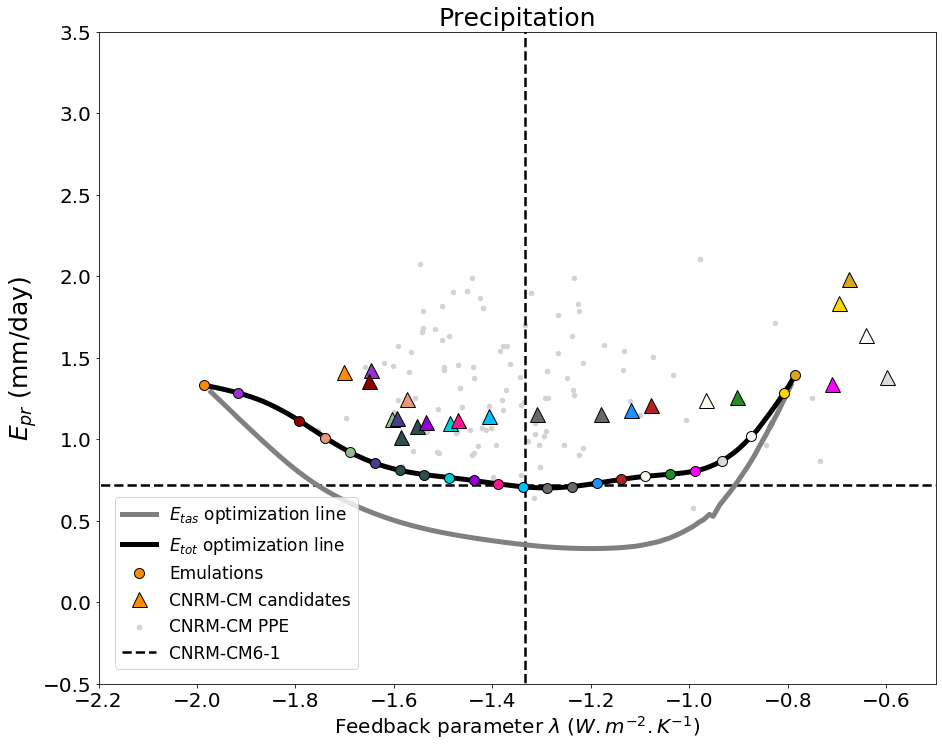

In [32]:
import matplotlib.colors as mcolors
import random

plt_colors = list(mcolors.CSS4_COLORS.keys())
st=30
colors=plt_colors[st:st+23]

cpt=0

ax = plt.gca()

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, 
                  linewidth=5, figsize=(15, 12), ax = ax)

df_optim_total_final.plot(kind='line', x='Fdbck', y='RMSE', color='black', alpha=1, 
                          linewidth=5, ax=ax)

PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='lightgray', 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5, zorder=1)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)


for i in colors :
    if cpt == 0 :
        ax.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], 
                 markerfacecolor=i, color='black', 
                 marker='o', linewidth=0, markersize=10, zorder=8)

        ax.plot(Fdbck_selection[cpt], E_df_selection[cpt], 
                 markerfacecolor=i, color='black',
                 marker='^', linewidth=0, markersize=15, zorder=9)
        cpt+=1
    else :
        ax.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], 
                 markerfacecolor=i, color='black',
                 marker='o', linewidth=0, markersize=10, label='_nolegend_')

        ax.plot(Fdbck_selection[cpt], E_df_selection[cpt], 
                 markerfacecolor=i, color='black',
                 marker='^', linewidth=0, markersize=15, label='_nolegend_')
        cpt+=1

legend = [ '$E_{tas}$ optimization line','$E_{tot}$ optimization line', 'Emulations',
          'CNRM-CM candidates', 'CNRM-CM PPE', 'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=20)
plt.ylabel(ylabel, fontsize=25)
plt.legend(legend, fontsize=17, bbox_to_anchor=(0.32, 0.30))

plt.title(TITLE, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-0.5,3.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_selection.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [31]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/E_selection_'+variable+'.npy', E_df_selection)

### [Back to the top](#top)

# <a id="correl">Check correlation with simple RMSE</a> </li> 

## Get the data 

In [165]:
# PPE amip simulations 
filename='*_amip_*.nc'


amip={}

for nb_p in nb_p_list :
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_pr_xarr(path, filename, variables)
    

In [179]:
filename='*_amip_*.nc'
amip_select={}

for nb_p in nb_p_select :
    path=path_PPE+'ENSEMBLE4_selection/CNRM-CM6-1_amip_PPE_ENSEMBLE4_selection/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    tmp = get_3D_pr_xarr(path, filename, variables)
    amip_select[str(nb_p)] = tmp.assign_coords(lat=amip_list[0]['lat'])
    

In [167]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/'
filename = 'pr_mon_mean_197901-201912_regrid.nc'
variable_obs = 'pr'

def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month

    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

path = path_observation
variables = [variable_obs]
df_obs = load_monthly_clim(path, filename, variables)
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.3159773 0.3089214 ... 0.50588834 0.50602216

In [168]:
# Reference p1
diff = (amip['p1'].values - obs[variable_obs].values)**2
diff_p1 = sqrt(sum(diff)/(128*256))
diff_p1

KeyError: 'p1'

In [169]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    mod = amip[p]*df_W
    observation = obs[variable_obs]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))

In [170]:
df_fig = pd.DataFrame(E_PPE, columns=['E_tas'])
df_fig['RMSE'] = ej_list
df_fig

E_tas      RMSE
0    1.327665  1.615625
1    1.119965  1.494008
2    1.131642  1.448093
3    1.485628  1.766993
4    0.947449  1.353116
..        ...       ...
97   1.312706  1.679986
98   0.641261  1.114605
99   0.787310  1.258110
100  0.788963  1.244036
101  0.489318  1.121599

[102 rows x 2 columns]

In [171]:
r = np.corrcoef(df_fig['E_tas'], df_fig['RMSE'])
r

array([[1.        , 0.98302322],
       [0.98302322, 1.        ]])

In [181]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_select :
    mod = amip_select[p]*df_W
    observation = obs[variable_obs]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))
    
df_fig_select = pd.DataFrame(E_df_selection, columns=['E_tas'])
df_fig_select['RMSE'] = ej_list
df_fig_select

E_tas      RMSE
0  0.742135  1.337348
1  0.777173  1.271089
2  0.762924  1.220048
3  0.770651  1.198474
4  0.860116  1.258519
5  0.845579  1.229315
6  0.853170  1.239550
7  0.901429  1.300929

In [182]:
r = np.corrcoef(df_fig_select['E_tas'], df_select['RMSE'])
r

array([[1.        , 0.02639514],
       [0.02639514, 1.        ]])

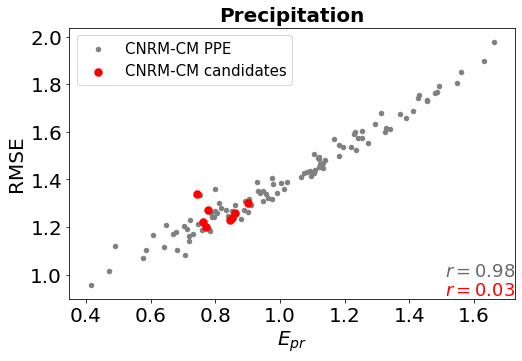

In [184]:
plt.figure(figsize=(8, 5))
    

ax = plt.gca()
#ax2 = ax.twinx()


df_fig.plot(kind='scatter', y='RMSE', x='E_tas', color = 'gray', alpha=1, ax=ax)
df_fig_select.plot(kind='scatter', y='RMSE', x='E_tas', color = 'red', linewidth=4, alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('$E_{pr}$', size = 20)
ax.set_ylabel('RMSE', size = 20)
ax.set_title('Precipitation', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.07,r'$r = 0.98$',horizontalalignment='right',color='dimgray',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.0,r'$r = 0.03$',horizontalalignment='right', color='red',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

#plt.xlim([0.0, 2.0])
#plt.ylim([0.0, 2.0])

# Legend .................

legend = [ 'CNRM-CM PPE', 'CNRM-CM candidates']
#ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)